In [3]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
import pickle

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
dataset = pd.read_csv('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/dataset.csv')

In [103]:
dataset = dataset.drop(columns=['hadm_id'])

In [104]:
dataset['Length of ICU stay'] = dataset['Length of ICU stay']/ (24*60*60)

In [105]:
dataset['race'] = dataset['race'].str.replace(r'.*AFRICAN AMERICAN.*', 'African american', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*WHITE.*', 'White', regex=True)
dataset['race'] = dataset['race'].str.replace(r'.*HISPANIC.*', 'Hispanic', regex=True)
dataset.loc[~dataset['race'].isin(['White', 'African american', 'Hispanic']), 'race'] = 'Other'
dataset['gender'] = dataset['gender'].str.replace(r'.*M.*', 'Male', regex=True)
dataset['gender'] = dataset['gender'].str.replace(r'.*F.*', 'Female', regex=True)

In [106]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30096 entries, 0 to 30095
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   stay_id                                  30096 non-null  int64  
 1   Age                                      30096 non-null  int64  
 2   gender                                   30096 non-null  object 
 3   race                                     30096 non-null  object 
 4   mortality                                30096 non-null  int64  
 5   Minimum creatinine                       29865 non-null  float64
 6   Maximum creatinine                       29865 non-null  float64
 7   Maximum creatinine during day2 and day3  29792 non-null  float64
 8   Maximum heart rate                       30035 non-null  float64
 9   Mean heart rate                          30035 non-null  float64
 10  Minimum systolic bp                      26528

## Univariate Statisitics

In [108]:
# eliminate outliers
dataset_copy = dataset.copy()
predictors_continuous = dataset_copy.drop(columns=['gender', 'race', 'mortality'])

predictors_continuous['Maximum creatinine'] = predictors_continuous['Maximum creatinine'].where(predictors_continuous['Maximum creatinine'] <= 50, np.nan)
predictors_continuous['Minimum creatinine'] = predictors_continuous['Minimum creatinine'].where(predictors_continuous['Minimum creatinine'] <= 50, np.nan)
predictors_continuous['Maximum creatinine during day2 and day3'] = predictors_continuous['Maximum creatinine during day2 and day3'].where(predictors_continuous['Maximum creatinine during day2 and day3'] <= 1000, np.nan)

predictors_continuous['Maximum heart rate'] = predictors_continuous['Maximum heart rate'].where(predictors_continuous['Maximum heart rate'] <= 300, np.nan)
predictors_continuous['Mean heart rate'] = predictors_continuous['Mean heart rate'].where(predictors_continuous['Mean heart rate'] <= 300, np.nan)

predictors_continuous['Minimum spo2'] = predictors_continuous['Minimum spo2'].where(predictors_continuous['Minimum spo2'] <= 100, np.nan)
predictors_continuous['Mean spo2'] = predictors_continuous['Mean spo2'].where(predictors_continuous['Mean spo2'] <= 100, np.nan)

predictors_continuous['Minimum prothrombin'] = predictors_continuous['Minimum prothrombin'].where(predictors_continuous['Minimum prothrombin'] <= 1000, np.nan)
predictors_continuous['Maximum prothrombin'] = predictors_continuous['Maximum prothrombin'].where(predictors_continuous['Maximum prothrombin'] <= 1000, np.nan)

predictors_continuous['Mean systolic bp'] = predictors_continuous['Mean systolic bp'].where(predictors_continuous['Mean systolic bp'] <= 500, np.nan)

predictors_continuous['Mean diastolic bp'] = predictors_continuous['Mean diastolic bp'].where(predictors_continuous['Mean diastolic bp'] <= 2000, np.nan)

predictors_continuous['Maximum respiratory rate'] = predictors_continuous['Maximum respiratory rate'].where(predictors_continuous['Maximum respiratory rate'] <= 500, np.nan)

predictors_continuous['Mean respiratory rate'] = predictors_continuous['Mean respiratory rate'].where(predictors_continuous['Mean respiratory rate'] <= 500, np.nan)

predictors_continuous['Maximum sodium'] = predictors_continuous['Maximum sodium'].where(predictors_continuous['Maximum sodium'] <= 500, np.nan)

# predictors_continuous['Sodium Mean'].plot()
# predictors_continuous.info()

In [311]:
mean = predictors_continuous.mean(axis=0, skipna=True)
std = predictors_continuous.std(axis=0, skipna=True)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.DataFrame({'Mean': mean, 'Std': std})

# predictors_continuous.info()

Mean          Std
stay_id                                 34980164.2865 2889898.3269
Age                                           66.2007      15.0437
Minimum creatinine                             1.4673       1.4932
Maximum creatinine                             1.6920       1.7530
Maximum creatinine during day2 and day3        1.6921       1.6897
Maximum heart rate                           128.2096      12.1901
Mean heart rate                               86.6983      13.8197
Minimum systolic bp                           93.5621      17.8224
Mean systolic bp                             116.9478      17.3460
Minimum diastolic bp                          47.9121      12.0750
Mean diastolic bp                             63.9940      13.7794
Minimum spo2                                  85.5181       3.2733
Mean spo2                                     86.0645       1.7501
Minimum hemoglobin                             9.8314       2.2236
Minimum prothrombin                           15.7592       6.6938
Maximum prothrombin                           17.7117      10.3300
Minimum respiratory rate                      11.9035       4.6741
Maximum respiratory rate                      28.9167       8.3498
Mean respiratory rate                         19.5822       4.0621
Maximum glucose                              165.0761      97.3101
Minimum platelet count                       196.1353     108.4844
Minimum calcium                                8.1540       0.8149
Minimum bicarbonate                           22.7164       4.1485
Maximum potassium                              4.4847       0.7651
Maximum blood urea nitrogen                   30.8979      23.5985
Maximum red blood cell count                   3.6340       0.6983
Minimum red blood cell count                   3.3347       0.7517
Mean red blood cell count                      3.4867       0.6967
Maximum white blood cell count                14.0756      10.7734
Maximum sodium                               139.8084       5.8098
Minimum sodium                               128.5421      27.3914
Mean sodium                                  135.9291       9.6161
SOFA score                                     4.8595       3.3491
APS-III score                                 46.3150      19.6420
Length of ICU stay                             6.0020       6.1980

In [110]:
predictors_categorical = dataset_copy[['stay_id', 'gender', 'race']]
predictors_categorical['gender'].value_counts() / predictors_categorical['gender'].count()
predictors_categorical['race'].value_counts() / predictors_categorical['race'].count()
# predictors_categorical.info()
# predictors_categorical['race'].value_counts()

White              0.68
Other              0.20
African american   0.09
Hispanic           0.03
Name: race, dtype: float64

## Bivariate accosiation

### imputation

In [111]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [112]:
df_raw = predictors_continuous.copy()
missing_mask = df_raw.isna()
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(df_raw)
imputed_df = pd.DataFrame(imputed_values, index=df_raw.index, columns=df_raw.columns)

In [113]:
df_raw[missing_mask] = imputed_df[missing_mask]
predictors_continuous = df_raw.copy()

### normaliztion

### Univariate Linear Regression

In [114]:
import statsmodels.api as sm
uni_linear_reg_Y = predictors_continuous[['Maximum creatinine during day2 and day3']]
uni_linear_reg_X = pd.merge(predictors_continuous.drop(columns=['Maximum creatinine during day2 and day3']), predictors_categorical, how='left', on='stay_id')
uni_linear_reg_X = uni_linear_reg_X.drop(columns=['stay_id'])
uni_linear_reg_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30096 entries, 0 to 30095
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             30096 non-null  int64  
 1   Minimum creatinine              30096 non-null  float64
 2   Maximum creatinine              30096 non-null  float64
 3   Maximum heart rate              30096 non-null  float64
 4   Mean heart rate                 30096 non-null  float64
 5   Minimum systolic bp             30096 non-null  float64
 6   Mean systolic bp                30096 non-null  float64
 7   Minimum diastolic bp            30096 non-null  float64
 8   Mean diastolic bp               30096 non-null  float64
 9   Minimum spo2                    30096 non-null  float64
 10  Mean spo2                       30096 non-null  float64
 11  Minimum hemoglobin              30096 non-null  float64
 12  Minimum prothrombin             

In [115]:
list_of_poi = uni_linear_reg_X.columns.to_list()
pois_cont = list_of_poi[:len(list_of_poi)-2]
pois_cate = list_of_poi[len(list_of_poi)-2:]
# pois_cate

In [116]:
results = []

for predictor in pois_cont:
    X = sm.add_constant(uni_linear_reg_X[predictor])
    Y = uni_linear_reg_Y

    model = sm.OLS(Y, X).fit()

    p_value = model.pvalues[predictor]
    conf_int = model.conf_int().loc[predictor]

    results.append({
        'Predictor': predictor,
        'Coefficient': model.params[predictor],
        'P-Value': p_value,
        '95% CI Lower': conf_int[0],
        '95% CI Upper': conf_int[1]
    })

results_uni_linear = pd.DataFrame(results)

In [117]:
X = pd.get_dummies(uni_linear_reg_X['gender'], drop_first=True)
X = sm.add_constant(X)
Y = uni_linear_reg_Y

model = sm.OLS(Y, X).fit()

p_value = model.pvalues['Male']
conf_int = model.conf_int().loc['Male']

results.append({
    'Predictor': 'Male',
    'Coefficient': model.params['Male'],
    'P-Value': p_value,
    '95% CI Lower': conf_int[0],
    '95% CI Upper': conf_int[1]
})
results_uni_linear = pd.DataFrame(results)

In [118]:
X = pd.get_dummies(uni_linear_reg_X['race'], drop_first=True)
X = sm.add_constant(X)
Y = uni_linear_reg_Y

model = sm.OLS(Y, X).fit()

p_value = model.pvalues['Hispanic']
conf_int = model.conf_int().loc['Hispanic']

results.append({
    'Predictor': 'Hispanic',
    'Coefficient': model.params['Hispanic'],
    'P-Value': p_value,
    '95% CI Lower': conf_int[0],
    '95% CI Upper': conf_int[1]
})

p_value = model.pvalues['White']
conf_int = model.conf_int().loc['White']

results.append({
    'Predictor': 'White',
    'Coefficient': model.params['White'],
    'P-Value': p_value,
    '95% CI Lower': conf_int[0],
    '95% CI Upper': conf_int[1]
})

p_value = model.pvalues['Other']
conf_int = model.conf_int().loc['Other']

results.append({
    'Predictor': 'Other',
    'Coefficient': model.params['Other'],
    'P-Value': p_value,
    '95% CI Lower': conf_int[0],
    '95% CI Upper': conf_int[1]
})

pd.set_option('display.float_format', '{:.3f}'.format)
results_uni_linear = pd.DataFrame(results)

In [119]:
results_uni_linear

Predictor  Coefficient  P-Value  95% CI Lower  \
0                              Age       -0.006    0.000        -0.007   
1               Minimum creatinine        1.041    0.000         1.036   
2               Maximum creatinine        0.881    0.000         0.877   
3               Maximum heart rate        0.001    0.237        -0.001   
4                  Mean heart rate       -0.001    0.381        -0.002   
5              Minimum systolic bp       -0.006    0.000        -0.007   
6                 Mean systolic bp       -0.002    0.000        -0.003   
7             Minimum diastolic bp       -0.013    0.000        -0.015   
8                Mean diastolic bp       -0.008    0.000        -0.009   
9                     Minimum spo2       -0.007    0.014        -0.013   
10                       Mean spo2       -0.024    0.000        -0.035   
11              Minimum hemoglobin       -0.131    0.000        -0.139   
12             Minimum prothrombin        0.028    0.000         0.025   
13             Maximum prothrombin        0.019    0.000         0.017   
14        Minimum respiratory rate       -0.016    0.000        -0.020   
15        Maximum respiratory rate        0.003    0.019         0.000   
16           Mean respiratory rate        0.005    0.043         0.000   
17                 Maximum glucose        0.001    0.000         0.001   
18          Minimum platelet count       -0.001    0.000        -0.002   
19                 Minimum calcium       -0.083    0.000        -0.107   
20             Minimum bicarbonate       -0.072    0.000        -0.077   
21               Maximum potassium        0.605    0.000         0.581   
22     Maximum blood urea nitrogen        0.041    0.000         0.041   
23    Maximum red blood cell count       -0.397    0.000        -0.424   
24    Minimum red blood cell count       -0.373    0.000        -0.398   
25       Mean red blood cell count       -0.416    0.000        -0.443   
26  Maximum white blood cell count        0.004    0.000         0.002   
27                  Maximum sodium       -0.020    0.000        -0.024   
28                  Minimum sodium       -0.008    0.000        -0.009   
29                     Mean sodium       -0.023    0.000        -0.025   
30                      SOFA score        0.211    0.000         0.206   
31                   APS-III score        0.032    0.000         0.031   
32              Length of ICU stay        0.016    0.000         0.013   
33                            Male        0.384    0.000         0.346   
34                        Hispanic       -0.487    0.000        -0.606   
35                           White       -0.837    0.000        -0.903   
36                           Other       -0.716    0.000        -0.792   

    95% CI Upper  
0         -0.005  
1          1.046  
2          0.886  
3          0.003  
4          0.001  
5         -0.005  
6         -0.001  
7         -0.012  
8         -0.006  
9         -0.001  
10        -0.013  
11        -0.122  
12         0.031  
13         0.020  
14        -0.012  
15         0.005  
16         0.010  
17         0.002  
18        -0.001  
19        -0.060  
20        -0.068  
21         0.629  
22         0.042  
23        -0.370  
24        -0.348  
25        -0.389  
26         0.006  
27        -0.017  
28        -0.007  
29        -0.021  
30         0.216  
31         0.032  
32         0.019  
33         0.422  
34        -0.368  
35        -0.771  
36        -0.641

### Univariate Logistic Regression

In [120]:
uni_logistic_reg_Y = dataset_copy['mortality']
uni_logistic_reg_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
uni_logistic_reg_X = uni_logistic_reg_X.drop(columns=['stay_id'])
# uni_logistic_reg_X.info()

In [121]:
list_of_poi = uni_logistic_reg_X.columns.to_list()
pois_cont = list_of_poi[:len(list_of_poi)-2]
pois_cate = list_of_poi[len(list_of_poi)-2:]

In [122]:
results = []

for predictor in pois_cont:
    X = sm.add_constant(uni_logistic_reg_X[predictor])
    Y = uni_logistic_reg_Y

    model = sm.Logit(Y, X).fit()

    p_value = model.pvalues[predictor]
    conf_int = model.conf_int().loc[predictor]

    results.append({
        'Predictor': predictor,
        'OR': np.exp(model.params[predictor]),
        'P-Value': p_value,
        '95% CI Lower': np.exp(conf_int[0]),
        '95% CI Upper': np.exp(conf_int[1])
    })

results_uni_logistic = pd.DataFrame(results)

Optimization terminated successfully.
         Current function value: 0.667417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687324
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681751
  

In [123]:
X = pd.get_dummies(uni_logistic_reg_X['gender'], drop_first=True)
X = sm.add_constant(X)
Y = uni_logistic_reg_Y

model = sm.Logit(Y, X).fit()

p_value = model.pvalues['Male']
conf_int = model.conf_int().loc['Male']

results.append({
    'Predictor': 'Male',
    'OR': np.exp(model.params['Male']),
    'P-Value': p_value,
    '95% CI Lower': np.exp(conf_int[0]),
    '95% CI Upper': np.exp(conf_int[1])
})
results_uni_logistic = pd.DataFrame(results)

Optimization terminated successfully.
         Current function value: 0.688607
         Iterations 4


In [124]:
X = pd.get_dummies(uni_logistic_reg_X['race'], drop_first=True)
X = sm.add_constant(X)
Y = uni_logistic_reg_Y

model = sm.Logit(Y, X).fit()

p_value = model.pvalues['Hispanic']
conf_int = model.conf_int().loc['Hispanic']

results.append({
    'Predictor': 'Hispanic',
    'OR': np.exp(model.params['Hispanic']),
    'P-Value': p_value,
    '95% CI Lower': np.exp(conf_int[0]),
    '95% CI Upper': np.exp(conf_int[1])
})

p_value = model.pvalues['White']
conf_int = model.conf_int().loc['White']

results.append({
    'Predictor': 'White',
    'OR': np.exp(model.params['White']),
    'P-Value': p_value,
    '95% CI Lower': np.exp(conf_int[0]),
    '95% CI Upper': np.exp(conf_int[1])
})

p_value = model.pvalues['Other']
conf_int = model.conf_int().loc['Other']

results.append({
    'Predictor': 'Other',
    'OR': np.exp(model.params['Other']),
    'P-Value': p_value,
    '95% CI Lower': np.exp(conf_int[0]),
    '95% CI Upper': np.exp(conf_int[1])
})

results_uni_logistic = pd.DataFrame(results)

Optimization terminated successfully.
         Current function value: 0.686636
         Iterations 4


In [125]:
results_uni_logistic

Predictor    OR  P-Value  95% CI Lower  \
0                                       Age 1.029    0.000         1.027   
1                        Minimum creatinine 1.259    0.000         1.236   
2                        Maximum creatinine 1.201    0.000         1.182   
3   Maximum creatinine during day2 and day3 1.232    0.000         1.213   
4                        Maximum heart rate 1.011    0.000         1.010   
5                           Mean heart rate 1.007    0.000         1.006   
6                       Minimum systolic bp 0.983    0.000         0.982   
7                          Mean systolic bp 0.990    0.000         0.989   
8                      Minimum diastolic bp 0.968    0.000         0.966   
9                         Mean diastolic bp 0.980    0.000         0.978   
10                             Minimum spo2 0.996    0.222         0.989   
11                                Mean spo2 0.993    0.263         0.980   
12                       Minimum hemoglobin 0.894    0.000         0.885   
13                      Minimum prothrombin 1.062    0.000         1.057   
14                      Maximum prothrombin 1.030    0.000         1.027   
15                 Minimum respiratory rate 1.036    0.000         1.031   
16                 Maximum respiratory rate 1.016    0.000         1.013   
17                    Mean respiratory rate 1.062    0.000         1.056   
18                          Maximum glucose 1.001    0.000         1.001   
19                   Minimum platelet count 1.000    0.382         1.000   
20                          Minimum calcium 0.959    0.003         0.932   
21                      Minimum bicarbonate 1.009    0.001         1.004   
22                        Maximum potassium 1.122    0.000         1.089   
23              Maximum blood urea nitrogen 1.025    0.000         1.023   
24             Maximum red blood cell count 0.594    0.000         0.574   
25             Minimum red blood cell count 0.730    0.000         0.708   
26                Mean red blood cell count 0.640    0.000         0.619   
27           Maximum white blood cell count 1.003    0.002         1.001   
28                           Maximum sodium 1.000    0.964         0.996   
29                           Minimum sodium 0.995    0.000         0.994   
30                              Mean sodium 0.988    0.000         0.985   
31                               SOFA score 1.136    0.000         1.128   
32                            APS-III score 1.037    0.000         1.035   
33                       Length of ICU stay 1.034    0.000         1.030   
34                                     Male 0.972    0.224         0.929   
35                                 Hispanic 0.552    0.000         0.478   
36                                    White 0.745    0.000         0.688   
37                                    Other 0.633    0.000         0.578   

    95% CI Upper  
0          1.031  
1          1.282  
2          1.219  
3          1.252  
4          1.013  
5          1.009  
6          0.985  
7          0.992  
8          0.970  
9          0.982  
10         1.003  
11         1.006  
12         0.903  
13         1.066  
14         1.033  
15         1.042  
16         1.019  
17         1.069  
18         1.001  
19         1.000  
20         0.986  
21         1.015  
22         1.156  
23         1.026  
24         0.615  
25         0.753  
26         0.662  
27         1.006  
28         1.004  
29         0.995  
30         0.990  
31         1.144  
32         1.038  
33         1.038  
34         1.018  
35         0.639  
36         0.806  
37         0.693

## Multivariable Linear Regression

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

mul_linear_reg_Y = predictors_continuous[['Maximum creatinine during day2 and day3']]
mul_linear_reg_X = pd.merge(predictors_continuous.drop(columns=['Maximum creatinine during day2 and day3']),
                            predictors_categorical, how='left', on='stay_id')
mul_linear_reg_X = mul_linear_reg_X.drop(columns=['stay_id'])

In [127]:
mul_linear_reg_Y['Maximum creatinine during day2 and day3'] = np.log(mul_linear_reg_Y['Maximum creatinine during day2 and day3'])

<ipython-input-127-1a4bfef785b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_linear_reg_Y['Maximum creatinine during day2 and day3'] = np.log(mul_linear_reg_Y['Maximum creatinine during day2 and day3'])


### Variables Selection by p-value

In [128]:
## linear regression model with all variables
variables_cont = mul_linear_reg_X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(mul_linear_reg_X['gender'], drop_first=True)
variable_race = pd.get_dummies(mul_linear_reg_X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)
y = mul_linear_reg_Y

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

linear_reg_all_variables = {'X':X, 'y':y, 'model':model}

In [129]:
print(linear_reg_all_variables['model'].summary())

                                       OLS Regression Results                                      
Dep. Variable:     Maximum creatinine during day2 and day3   R-squared:                       0.738
Model:                                                 OLS   Adj. R-squared:                  0.738
Method:                                      Least Squares   F-statistic:                     2294.
Date:                                     Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                                             19:02:10   Log-Likelihood:                -11756.
No. Observations:                                    30096   AIC:                         2.359e+04
Df Residuals:                                        30058   BIC:                         2.390e+04
Df Model:                                               37                                         
Covariance Type:                                 nonrobust                                         


In [130]:
## linear regression model following backward selection
variables_cont = mul_linear_reg_X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(mul_linear_reg_X['gender'], drop_first=True)
variable_race = pd.get_dummies(mul_linear_reg_X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)
y = mul_linear_reg_Y

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

p_values = model.pvalues
max_p_value = p_values.max()

while True:
    if max_p_value >= 0.05:
        max_p_variable = p_values.idxmax()
        X = X.drop(columns=[max_p_variable])
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
    else:
        linear_reg_backward_selection = {'X':X, 'y':y, 'model':model}
        break

In [131]:
print(linear_reg_backward_selection['model'].summary())

                                       OLS Regression Results                                      
Dep. Variable:     Maximum creatinine during day2 and day3   R-squared:                       0.738
Model:                                                 OLS   Adj. R-squared:                  0.738
Method:                                      Least Squares   F-statistic:                     2927.
Date:                                     Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                                             19:02:17   Log-Likelihood:                -11759.
No. Observations:                                    30096   AIC:                         2.358e+04
Df Residuals:                                        30066   BIC:                         2.383e+04
Df Model:                                               29                                         
Covariance Type:                                 nonrobust                                         


### Cross-Validation

In [132]:
X = mul_linear_reg_X
y = mul_linear_reg_Y
Y.info()
mul_linear_reg_X
mul_linear_reg_Y

<class 'pandas.core.series.Series'>
RangeIndex: 30096 entries, 0 to 30095
Series name: mortality
Non-Null Count  Dtype
--------------  -----
30096 non-null  int64
dtypes: int64(1)
memory usage: 235.2 KB


Maximum creatinine during day2 and day3
0                                        0.262
1                                        0.182
2                                        0.833
3                                       -0.223
4                                       -0.916
...                                        ...
30091                                    0.531
30092                                   -0.357
30093                                   -0.223
30094                                   -0.511
30095                                   -0.357

[30096 rows x 1 columns]

In [133]:
## All Variables
X = linear_reg_all_variables['X']
y = linear_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Create a pipeline that preprocesses the data and then fits a linear regression model
model = Pipeline(steps=[('regressor', LinearRegression())])

# Define cross-validation strategy and scoring metric
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=1)
scoring_metric = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring=scoring_metric)

In [134]:
print(cv_scores)
cv_scores.mean()

[0.35427851 0.35503609 0.35322731 0.35062458 0.34740946 0.36853969
 0.36259756 0.35838712 0.36019731 0.37146381]


0.35817614370427525

In [135]:
## Backward Selection
X = linear_reg_backward_selection['X']
y = linear_reg_backward_selection['y']

# Create a pipeline that preprocesses the data and then fits a linear regression model
model = Pipeline(steps=[('regressor', LinearRegression())])

# Define cross-validation strategy and scoring metric
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=1)
scoring_metric = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring=scoring_metric)

In [136]:
print(cv_scores)
cv_scores.mean()

[0.3543017  0.35504176 0.35305995 0.35066403 0.34732607 0.36861979
 0.3624926  0.35827717 0.36017157 0.37114334]


0.35810979614851796

## Multivariable Logistic Regression

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

mul_logistic_reg_Y = dataset_copy['mortality']

mul_logistic_reg_X = pd.merge(predictors_continuous,
                            predictors_categorical, how='left', on='stay_id')
mul_logistic_reg_X = mul_logistic_reg_X.drop(columns=['stay_id'])

In [138]:
df= mul_logistic_reg_X.drop(columns=['gender', 'race']).copy()
normalized_df = (df - df.mean()) / df.std()
mul_logistic_reg_X = pd.concat([normalized_df, mul_logistic_reg_X[['gender', 'race']]], axis=1)

In [139]:
mul_logistic_reg_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30096 entries, 0 to 30095
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Age                                      30096 non-null  float64
 1   Minimum creatinine                       30096 non-null  float64
 2   Maximum creatinine                       30096 non-null  float64
 3   Maximum creatinine during day2 and day3  30096 non-null  float64
 4   Maximum heart rate                       30096 non-null  float64
 5   Mean heart rate                          30096 non-null  float64
 6   Minimum systolic bp                      30096 non-null  float64
 7   Mean systolic bp                         30096 non-null  float64
 8   Minimum diastolic bp                     30096 non-null  float64
 9   Mean diastolic bp                        30096 non-null  float64
 10  Minimum spo2                             30096

### Variables Selection by p-value

In [306]:
## logistic regression model with all variables
variables_cont = mul_logistic_reg_X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(mul_logistic_reg_X['gender'], drop_first=True)
variable_race = pd.get_dummies(mul_logistic_reg_X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)
y = mul_logistic_reg_Y

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()

logistic_reg_all_variables = {'X':X, 'y':y, 'model':model}

Optimization terminated successfully.
         Current function value: 0.587598
         Iterations 5


In [321]:
odds_ratios = np.exp(model.params)
conf = model.conf_int()
# conf = np.exp(conf)
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
odds_ratio_conf = np.exp(conf)
odds_ratio_conf

2.5%  97.5%     OR
const                                   1.0364 1.2357 3.1009
Age                                     1.4937 1.5815 4.6507
Minimum creatinine                      1.0426 1.2859 3.1831
Maximum creatinine                      0.6624 0.8178 2.0876
Maximum creatinine during day2 and day3 1.0958 1.2577 3.2348
Mean heart rate                         1.0121 1.0715 2.8331
Minimum systolic bp                     0.8346 0.9043 2.3839
Mean systolic bp                        1.0188 1.1038 2.8877
Minimum hemoglobin                      0.8067 0.9051 2.3501
Minimum prothrombin                     1.1562 1.2273 3.2910
Minimum respiratory rate                1.0425 1.1130 2.9363
Maximum respiratory rate                0.8983 0.9617 2.5332
Mean respiratory rate                   1.0467 1.1351 2.9743
Maximum glucose                         1.0191 1.0774 2.8516
Minimum calcium                         1.0037 1.0625 2.8085
Minimum bicarbonate                     1.0983 1.1620 3.0949
Maximum blood urea nitrogen             1.1839 1.2773 3.4202
Maximum red blood cell count            0.5355 0.6011 1.7636
Minimum red blood cell count            1.5711 1.8520 5.5057
SOFA score                              1.0316 1.1121 2.9185
APS-III score                           1.5654 1.6961 5.1008
Length of ICU stay                      1.1256 1.1883 3.1789
Male                                    1.0062 1.1175 2.8875
Hispanic                                0.5304 0.7330 1.8655
Other                                   0.5506 0.6768 1.8413
White                                   0.6175 0.7417 1.9675

In [141]:
print(logistic_reg_all_variables['model'].summary())

                           Logit Regression Results                           
Dep. Variable:              mortality   No. Observations:                30096
Model:                          Logit   Df Residuals:                    30057
Method:                           MLE   Df Model:                           38
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1467
Time:                        19:04:02   Log-Likelihood:                -17684.
converged:                       True   LL-Null:                       -20725.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.1220      0.045      2.713      0.007       0.034       0.210
Age                                         

In [313]:
## logistic regression model following backward selection
variables_cont = mul_logistic_reg_X.drop(columns=['gender', 'race'])
variable_gender = pd.get_dummies(mul_logistic_reg_X['gender'], drop_first=True)
variable_race = pd.get_dummies(mul_logistic_reg_X['race'], drop_first=True)
X = pd.concat([pd.concat([variables_cont, variable_gender], axis=1), variable_race], axis=1)
y = mul_logistic_reg_Y

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()

p_values = model.pvalues
max_p_value = p_values.max()

while True:
    if max_p_value >= 0.05:
        max_p_variable = p_values.idxmax()
        X = X.drop(columns=[max_p_variable])
        model = sm.Logit(y, X).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
    else:
        logistic_reg_backward_selection = {'X':X, 'y':y, 'model':model}
        break

Optimization terminated successfully.
         Current function value: 0.587598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587679
  

In [316]:
odds_ratios = np.exp(model.params)

# Get confidence intervals
conf_int = model.conf_int()
conf_int = np.exp(conf_int)  # Convert log odds to odds ratios

# Create a DataFrame for holding odds ratios and their confidence intervals
odds_ratio_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5% CI': conf_int[0],
    '97.5% CI': conf_int[1]
})

# Include p-values in the DataFrame
odds_ratio_df['p-value'] = model.pvalues

# Print or output the final DataFrame
odds_ratio_df

Odds Ratio  2.5% CI  97.5% CI  \
const                                        1.1317   1.0364    1.2357   
Age                                          1.5370   1.4937    1.5815   
Minimum creatinine                           1.1579   1.0426    1.2859   
Maximum creatinine                           0.7360   0.6624    0.8178   
Maximum creatinine during day2 and day3      1.1740   1.0958    1.2577   
Mean heart rate                              1.0414   1.0121    1.0715   
Minimum systolic bp                          0.8688   0.8346    0.9043   
Mean systolic bp                             1.0605   1.0188    1.1038   
Minimum hemoglobin                           0.8545   0.8067    0.9051   
Minimum prothrombin                          1.1912   1.1562    1.2273   
Minimum respiratory rate                     1.0771   1.0425    1.1130   
Maximum respiratory rate                     0.9295   0.8983    0.9617   
Mean respiratory rate                        1.0900   1.0467    1.1351   
Maximum glucose                              1.0479   1.0191    1.0774   
Minimum calcium                              1.0327   1.0037    1.0625   
Minimum bicarbonate                          1.1297   1.0983    1.1620   
Maximum blood urea nitrogen                  1.2297   1.1839    1.2773   
Maximum red blood cell count                 0.5673   0.5355    0.6011   
Minimum red blood cell count                 1.7058   1.5711    1.8520   
SOFA score                                   1.0711   1.0316    1.1121   
APS-III score                                1.6294   1.5654    1.6961   
Length of ICU stay                           1.1565   1.1256    1.1883   
Male                                         1.0604   1.0062    1.1175   
Hispanic                                     0.6235   0.5304    0.7330   
Other                                        0.6105   0.5506    0.6768   
White                                        0.6768   0.6175    0.7417   

                                         p-value  
const                                     0.0058  
Age                                       0.0000  
Minimum creatinine                        0.0062  
Maximum creatinine                        0.0000  
Maximum creatinine during day2 and day3   0.0000  
Mean heart rate                           0.0054  
Minimum systolic bp                       0.0000  
Mean systolic bp                          0.0041  
Minimum hemoglobin                        0.0000  
Minimum prothrombin                       0.0000  
Minimum respiratory rate                  0.0000  
Maximum respiratory rate                  0.0000  
Mean respiratory rate                     0.0000  
Maximum glucose                           0.0010  
Minimum calcium                           0.0269  
Minimum bicarbonate                       0.0000  
Maximum blood urea nitrogen               0.0000  
Maximum red blood cell count              0.0000  
Minimum red blood cell count              0.0000  
SOFA score                                0.0003  
APS-III score                             0.0000  
Length of ICU stay                        0.0000  
Male                                      0.0285  
Hispanic                                  0.0000  
Other                                     0.0000  
White                                     0.0000

In [143]:
print(logistic_reg_backward_selection['model'].summary())

                           Logit Regression Results                           
Dep. Variable:              mortality   No. Observations:                30096
Model:                          Logit   Df Residuals:                    30070
Method:                           MLE   Df Model:                           25
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1464
Time:                        19:04:09   Log-Likelihood:                -17691.
converged:                       True   LL-Null:                       -20725.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.1237      0.045      2.758      0.006       0.036       0.212
Age                                         

### Cross-Validation

In [322]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

model = Pipeline(steps=[('classifier', LogisticRegression(solver='newton-cholesky'))])

cv_strategy = KFold(n_splits=10, shuffle=True)

In [323]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_LR_allVar = {}
for score_name, scorer in scoring.items():
    perfomances_LR_allVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [324]:
perfomances_LR_allVar

{'ROC_auc': 0.7503083281859647,
 'Accuracy': 0.6854736344675829,
 'Sensitivity': 0.5992588156520344,
 'Specificity': 0.7578805246224227,
 'PPV': 0.6720651223850629,
 'NPV': 0.6962215361986238}

### feature importence by SHAP value

In [147]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
# Prepares a default instance of the random forest regressor
model = LogisticRegression(solver='newton-cholesky', random_state=1)
# Fits the model on the data
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='newton-cholesky')

In [148]:
import shap

explainer = shap.Explainer(model.predict, X_test[:100])

shap_values = explainer(X_test[:100])

PermutationExplainer explainer: 101it [00:10,  2.59it/s]                         


In [149]:
LogsticReg_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/LogsticReg_shap_values.pickle', 'wb') as f:
    pickle.dump(LogsticReg_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/LogsticReg_shap_values.pickle', 'rb') as f:
    LogsticReg_shap_values = pickle.load(f)

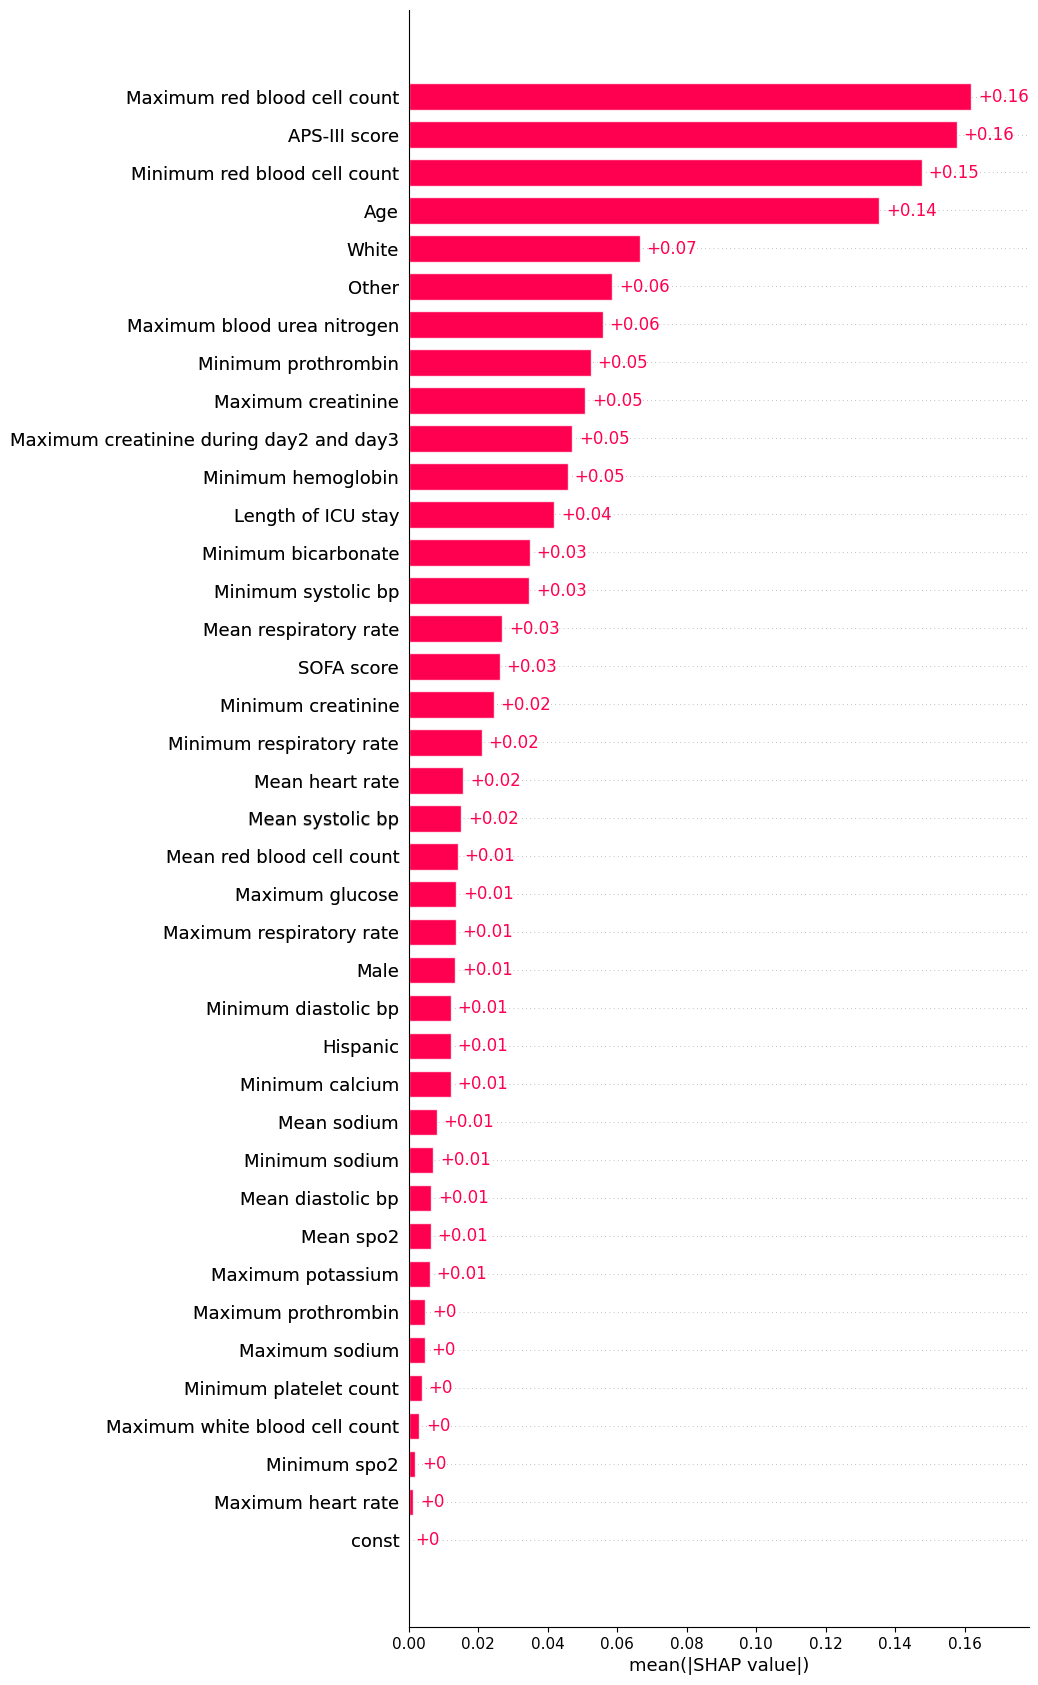

In [150]:
shap.plots.bar(LogsticReg_shap_values, max_display=40)

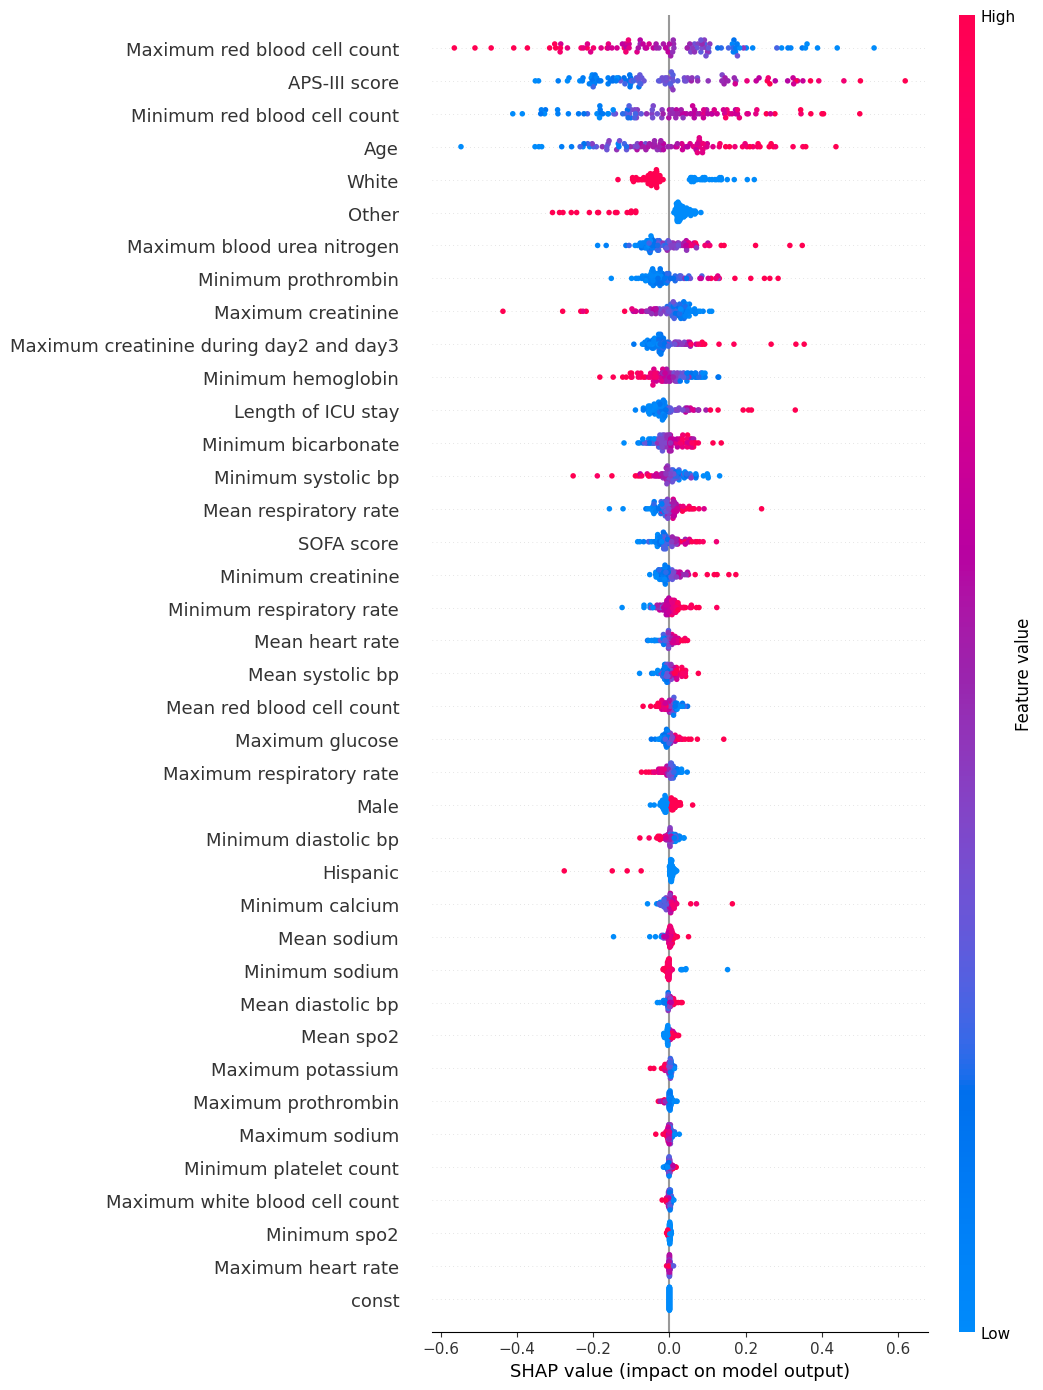

In [151]:
shap.plots.beeswarm(LogsticReg_shap_values, max_display=40)

### backward selection

In [152]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [153]:
LR_selected_features = print_feature_importances_shap_values(LogsticReg_shap_values, X_test.columns)

In [325]:
## Backward Selection
X = logistic_reg_all_variables['X'][LR_selected_features]
y = logistic_reg_all_variables['y']

model = Pipeline(steps=[('classifier', LogisticRegression(solver='newton-cholesky'))])

cv_strategy = KFold(n_splits=5, shuffle=True)

In [326]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_LR_BS = {}
for score_name, scorer in scoring.items():
    perfomances_LR_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [327]:
perfomances_LR_BS

{'ROC_auc': 0.7500182458176271,
 'Accuracy': 0.6860381438843441,
 'Sensitivity': 0.6004459393848716,
 'Specificity': 0.7586607553127794,
 'PPV': 0.6728384857191291,
 'NPV': 0.6949561164013452}

### Plot

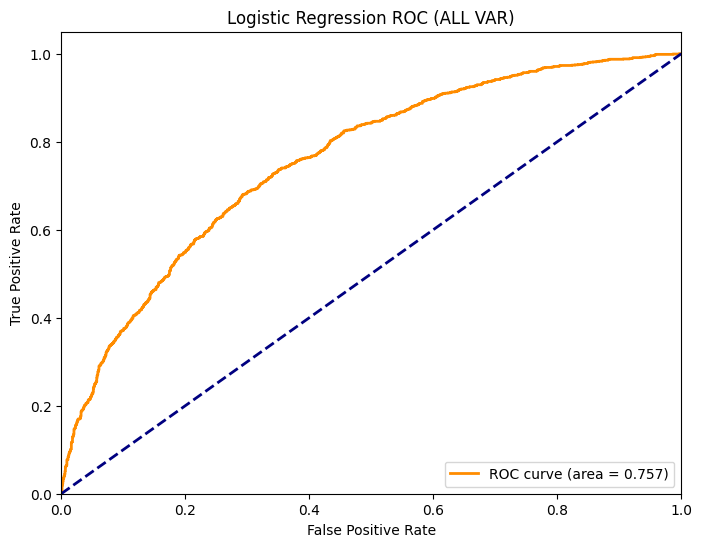

In [177]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = LogisticRegression(solver='newton-cholesky', random_state=1)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_LR_all, tpr_LR_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_LR_all = auc(fpr_LR_all, tpr_LR_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_LR_all, tpr_LR_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_LR_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC (ALL VAR)')
plt.legend(loc="lower right")
plt.show()

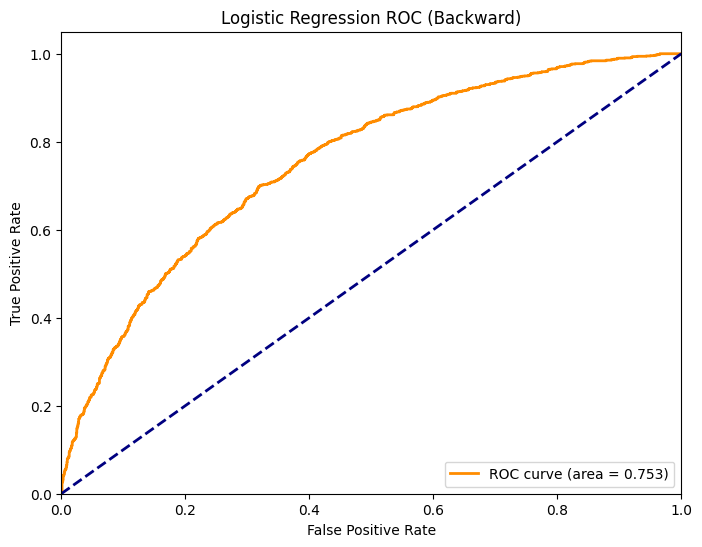

In [180]:
X = logistic_reg_all_variables['X'][LR_selected_features]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = LogisticRegression(solver='newton-cholesky', random_state=1)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_LR_backward, tpr_LR_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_LR_backward = auc(fpr_LR_backward, tpr_LR_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_LR_backward, tpr_LR_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_LR_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC (Backward)')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# RF_Y = dataset_copy['mortality']
# RF_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# RF_X = RF_X.drop(columns=['stay_id'])

### Cross-Validation

In [182]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

# categorical_cols = X.select_dtypes(include=['object', 'category']).columns
# continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

model = make_pipeline(RandomForestClassifier())

cv_strategy = KFold(n_splits=10, shuffle=True, random_state=1)

In [183]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomences_RF_allVar = {}
for score_name, scorer in scoring.items():
    perfomences_RF_allVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [ ]:
perfomences_RF_allVar

{'ROC_auc': 0.7627898083918341,
 'Accuracy': 0.6955745719651676,
 'Sensitivity': 0.6290802980114443,
 'Specificity': 0.7504643464381878,
 'PPV': 0.6758863192986615,
 'NPV': 0.7099889549591273}

### feature importence by SHAP value

In [ ]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
import shap

explainer = shap.Explainer(model.predict, X_test[:100])

shap_values = explainer(X_test[:100])

PermutationExplainer explainer: 3011it [36:46,  1.36it/s]


In [185]:
RandomForest_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/RandomForest_shap_values.pickle', 'wb') as f:
    pickle.dump(RandomForest_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/RandomForest_shap_values.pickle', 'rb') as f:
    RandomForest_shap_values = pickle.load(f)

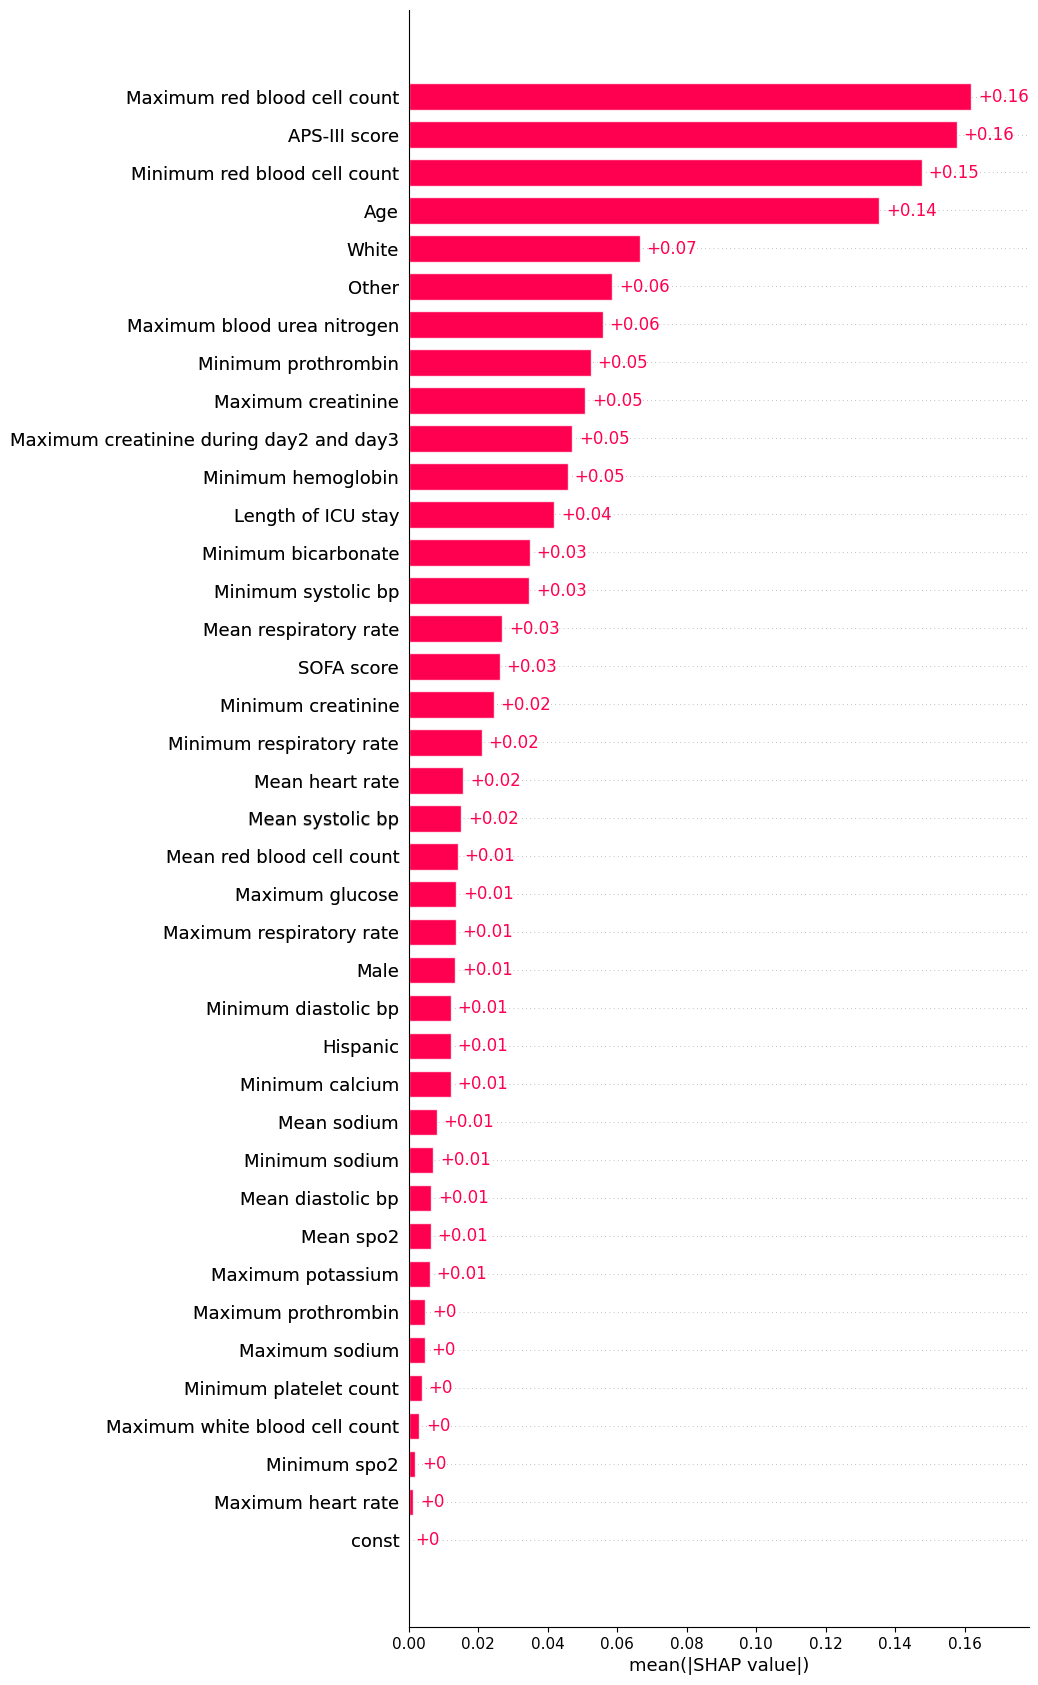

In [186]:
shap.plots.bar(RandomForest_shap_values, max_display=40)

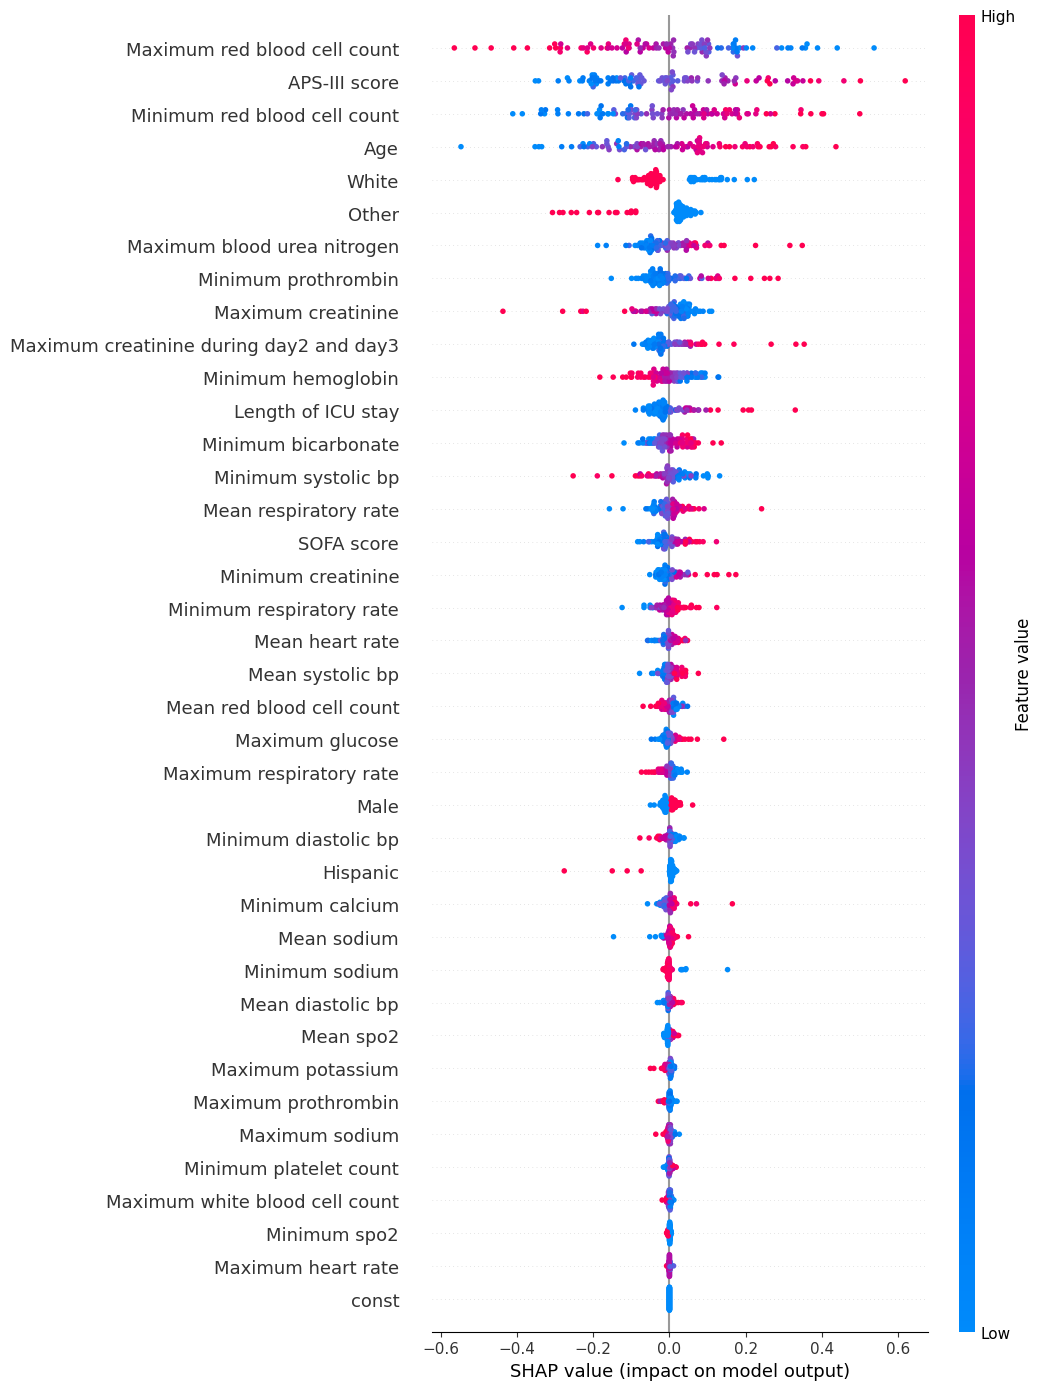

In [191]:
shap.plots.beeswarm(RandomForest_shap_values, max_display=40)

### backward selection

In [188]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [189]:
selected_features_RF = print_feature_importances_shap_values(RandomForest_shap_values, X_test.columns)

In [195]:
RandomForest_shap_values.shape
# type(RandomForest_shap_values)
RandomForest_shap_values.values.shape

(100, 39)

In [197]:
## Backward Selection
X = logistic_reg_all_variables['X'][selected_features_RF]
y = logistic_reg_all_variables['y']

model = make_pipeline(RandomForestClassifier())

cv_strategy = KFold(n_splits=5, shuffle=True)

In [198]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_RF_BS = {}
for score_name, scorer in scoring.items():
    perfomances_RF_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [199]:
perfomances_RF_BS

{'ROC_auc': 0.755914839655211,
 'Accuracy': 0.6893943542017278,
 'Sensitivity': 0.6146636897141051,
 'Specificity': 0.74594668682327,
 'PPV': 0.6683529523329959,
 'NPV': 0.7046082958060874}

### Plot

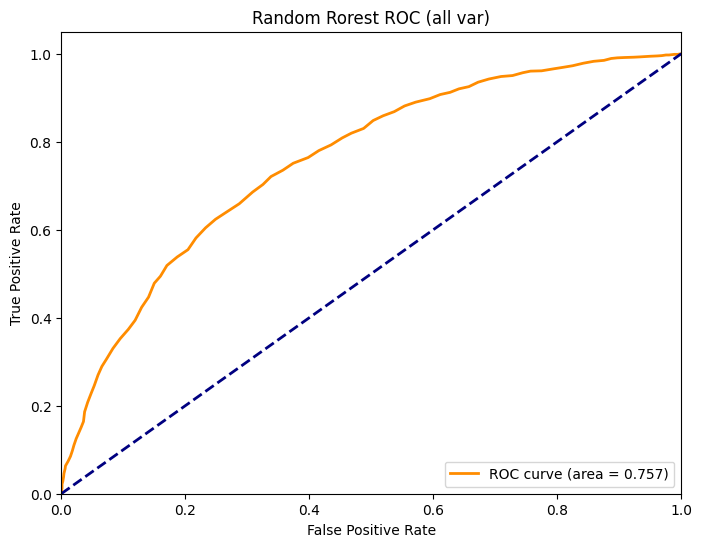

In [201]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_RF_all, tpr_RF_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_RF_all = auc(fpr_RF_all, tpr_RF_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_RF_all, tpr_RF_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_RF_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Rorest ROC (all var)')
plt.legend(loc="lower right")
plt.show()

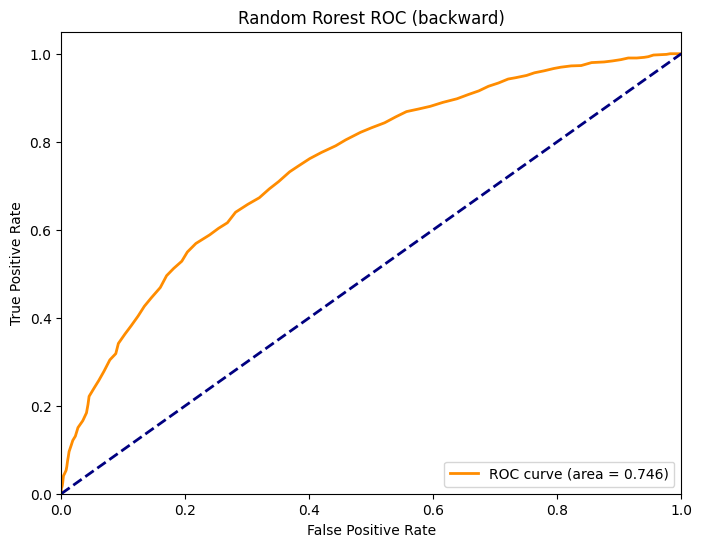

In [202]:
X = logistic_reg_all_variables['X'][selected_features_RF]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = RandomForestClassifier(random_state=1)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]

fpr_RF_backward, tpr_RF_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_RF_backward = auc(fpr_RF_backward, tpr_RF_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_RF_backward, tpr_RF_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_RF_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Rorest ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Multi-layer Preceptron

In [203]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# MLP_Y = dataset_copy['mortality']
# MLP_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# MLP_X = MLP_X.drop(columns=['stay_id'])

### Cross-Validation

In [204]:
## All Variables
# X = MLP_X
# y = MLP_Y
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    MLPClassifier(hidden_layer_sizes=(7,4))
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [205]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_MLP_AllVar = {}
for score_name, scorer in scoring.items():
    perfomances_MLP_AllVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [206]:
perfomances_MLP_AllVar

{'ROC_auc': 0.7614026057926023,
 'Accuracy': 0.6936139544819037,
 'Sensitivity': 0.6490145746322206,
 'Specificity': 0.73064325172177,
 'PPV': 0.6658669314794612,
 'NPV': 0.7158753457134372}

### feature importence by SHAP value

In [207]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
# Prepares a default instance of the random forest regressor
model = MLPClassifier(hidden_layer_sizes=(7,4), random_state=1)
# Fits the model on the data
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(7, 4), random_state=1)

In [208]:
import shap

explainer = shap.Explainer(model.predict, X_test[:100])

shap_values = explainer(X_test[:100])

In [209]:
MLP_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/MLP_shap_values.pickle', 'wb') as f:
    pickle.dump(MLP_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/MLP_shap_values.pickle', 'rb') as f:
    MLP_shap_values = pickle.load(f)

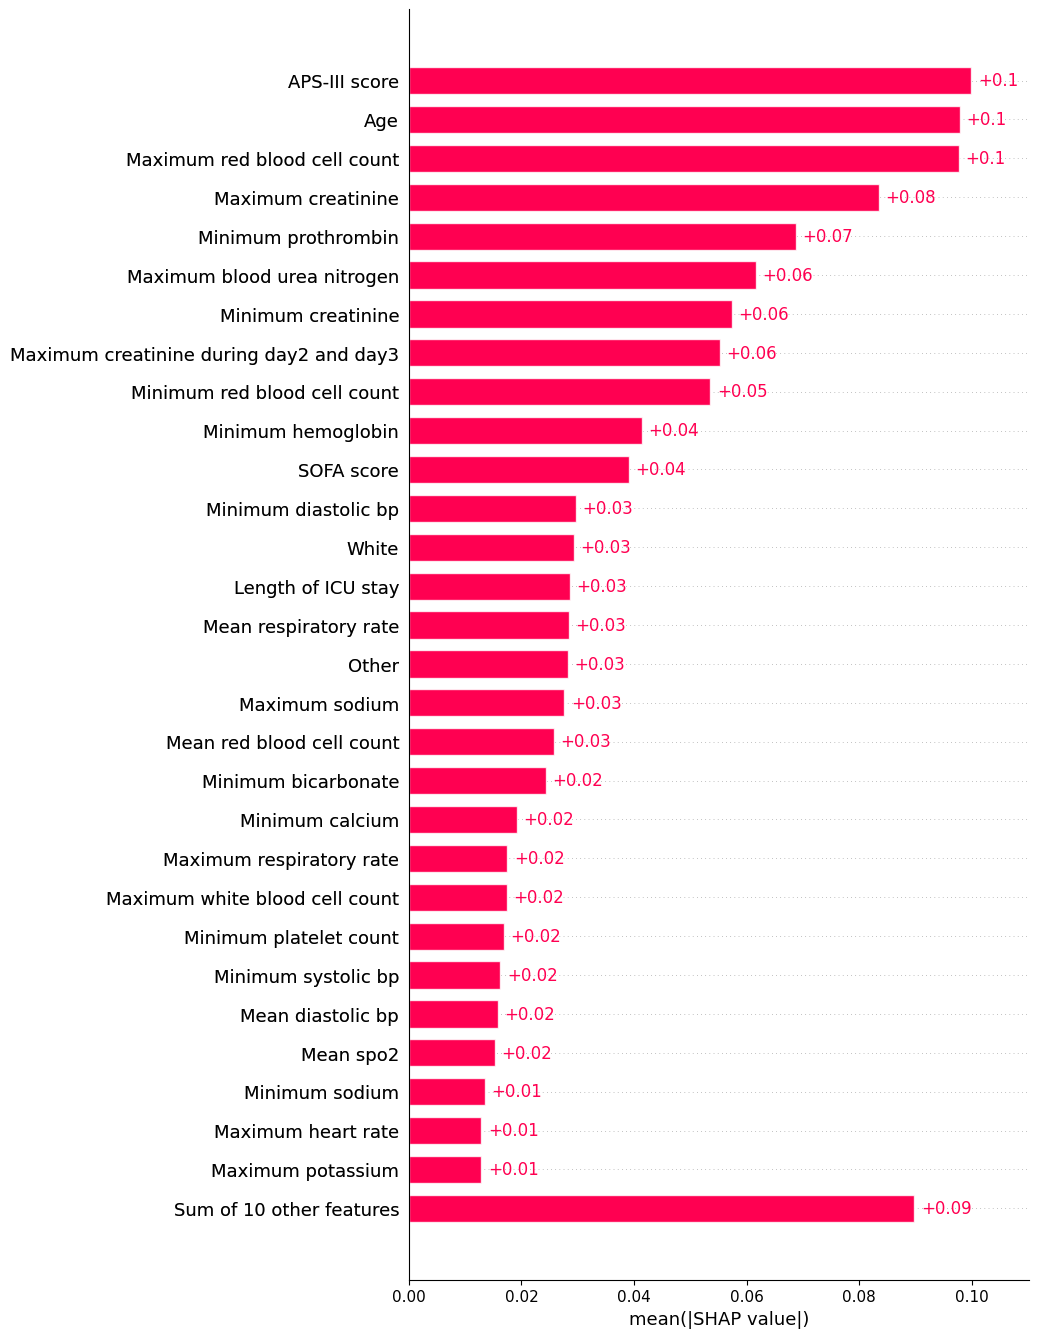

In [210]:
shap.plots.bar(MLP_shap_values, max_display=30)

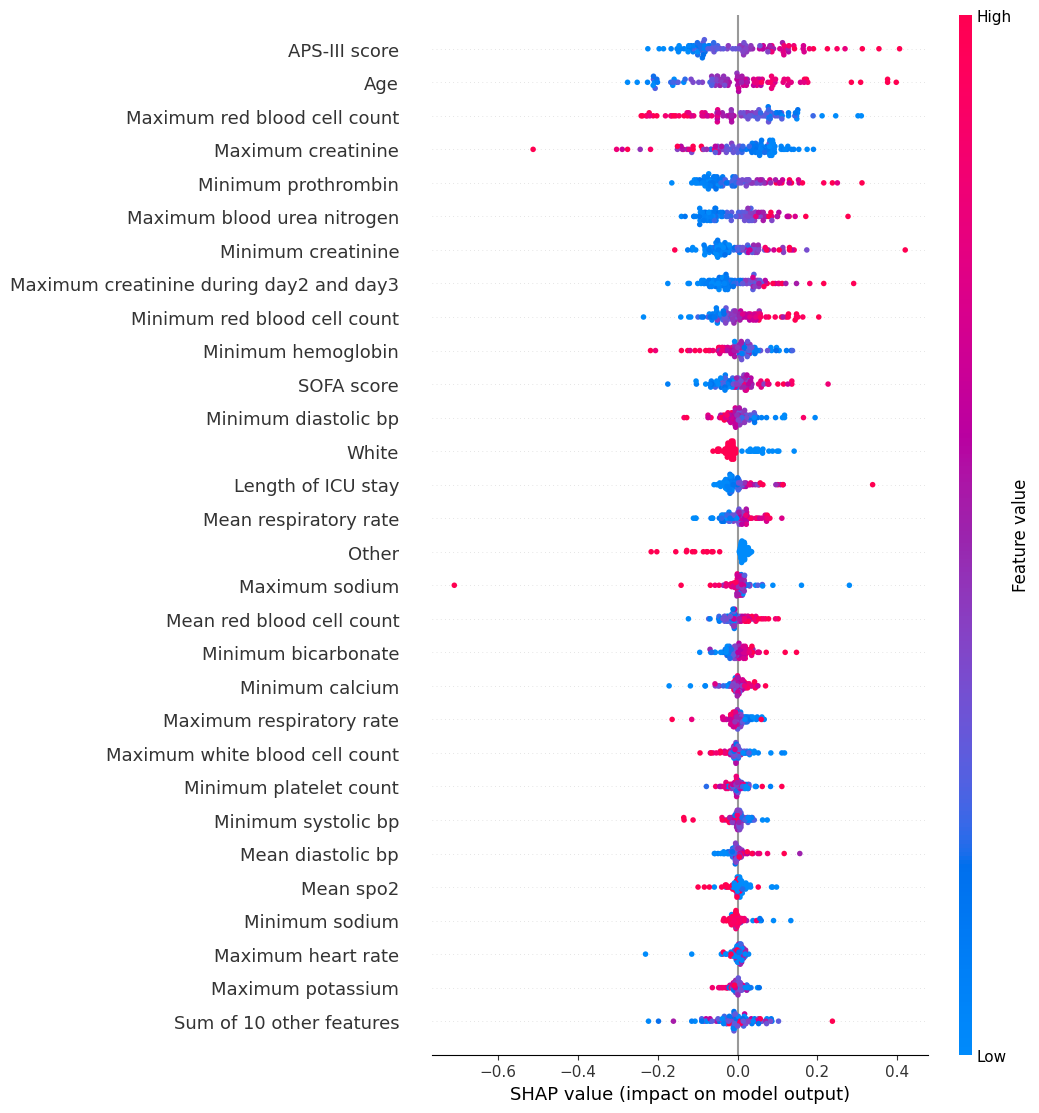

In [211]:
shap.plots.beeswarm(MLP_shap_values, max_display=30)

### backward selection

In [212]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [213]:
selected_features_MLP = print_feature_importances_shap_values(MLP_shap_values, X_test.columns)

In [216]:
## Backward Selection
# X = MLP_X
# y = MLP_Y
X = logistic_reg_all_variables['X'][selected_features_MLP]
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    MLPClassifier(hidden_layer_sizes=(7,4))
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [217]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_MLP_BS = {}
for score_name, scorer in scoring.items():
    perfomances_MLP_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [218]:
perfomances_MLP_BS

{'ROC_auc': 0.7585018388021467,
 'Accuracy': 0.6919190779585576,
 'Sensitivity': 0.6386503603621339,
 'Specificity': 0.7350231513446057,
 'PPV': 0.6681402884687224,
 'NPV': 0.7144434012421401}

### Plot

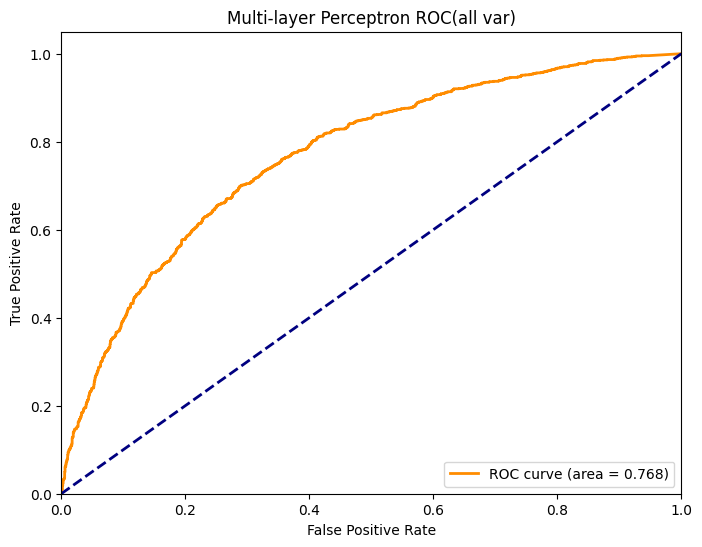

In [220]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = MLPClassifier(hidden_layer_sizes=(7,4))
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]
fpr_MLP_all, tpr_MLP_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_MLP_all = auc(fpr_MLP_all, tpr_MLP_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_MLP_all, tpr_MLP_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_MLP_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-layer Perceptron ROC(all var)')
plt.legend(loc="lower right")
plt.show()

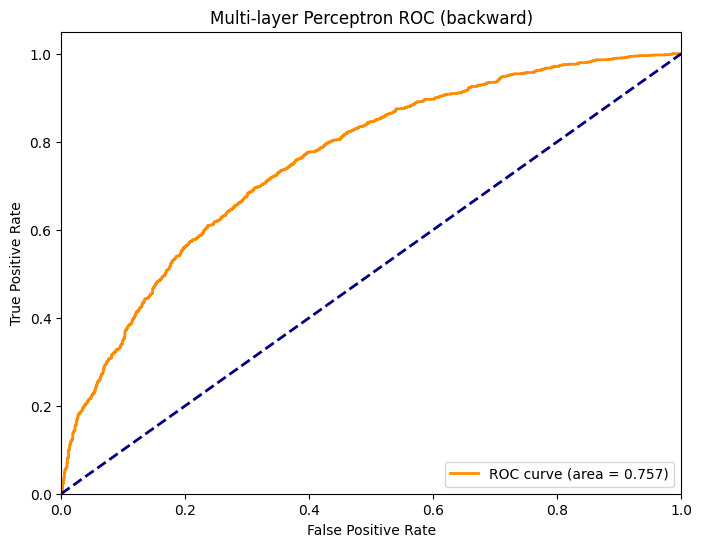

In [221]:
X = logistic_reg_all_variables['X'][selected_features_MLP]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = MLPClassifier(hidden_layer_sizes=(7,4))
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_MLP_backward, tpr_MLP_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_MLP_backward = auc(fpr_MLP_backward, tpr_MLP_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_MLP_backward, tpr_MLP_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_MLP_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-layer Perceptron ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Support Vector Machine

In [222]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier

# SVC_Y = dataset_copy['mortality']
# SVC_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# SVC_X = SVC_X.drop(columns=['stay_id'])

### Cross-Validation

In [225]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
     SGDClassifier(max_iter=1000, random_state=1, loss='log_loss')
    # LinearSVC(C=0.1, max_iter=4000, random_state=1)
    # SVC(probability=True, random_state=1)
)

cv_strategy = KFold(n_splits=10, shuffle=True)

In [226]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_SVM_AllVar = {}
for score_name, scorer in scoring.items():
    perfomances_SVM_AllVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [227]:
perfomances_SVM_AllVar

{'ROC_auc': 0.7364639041285175,
 'Accuracy': 0.6813535362903538,
 'Sensitivity': 0.5907134910259829,
 'Specificity': 0.7541613552128053,
 'PPV': 0.6574602391407073,
 'NPV': 0.6923954517085109}

### feature importence by SHAP value

In [228]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

model = SGDClassifier(max_iter=1000, random_state=1, loss='log_loss')

model.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=1)

In [229]:
import shap

explainer = shap.Explainer(model.predict, X_test[:100])

shap_values = explainer(X_test[:100])

In [230]:
SVM_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/SVM_shap_values.pickle', 'wb') as f:
    pickle.dump(SVM_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/SVM_shap_values.pickle', 'rb') as f:
    SVM_shap_values = pickle.load(f)

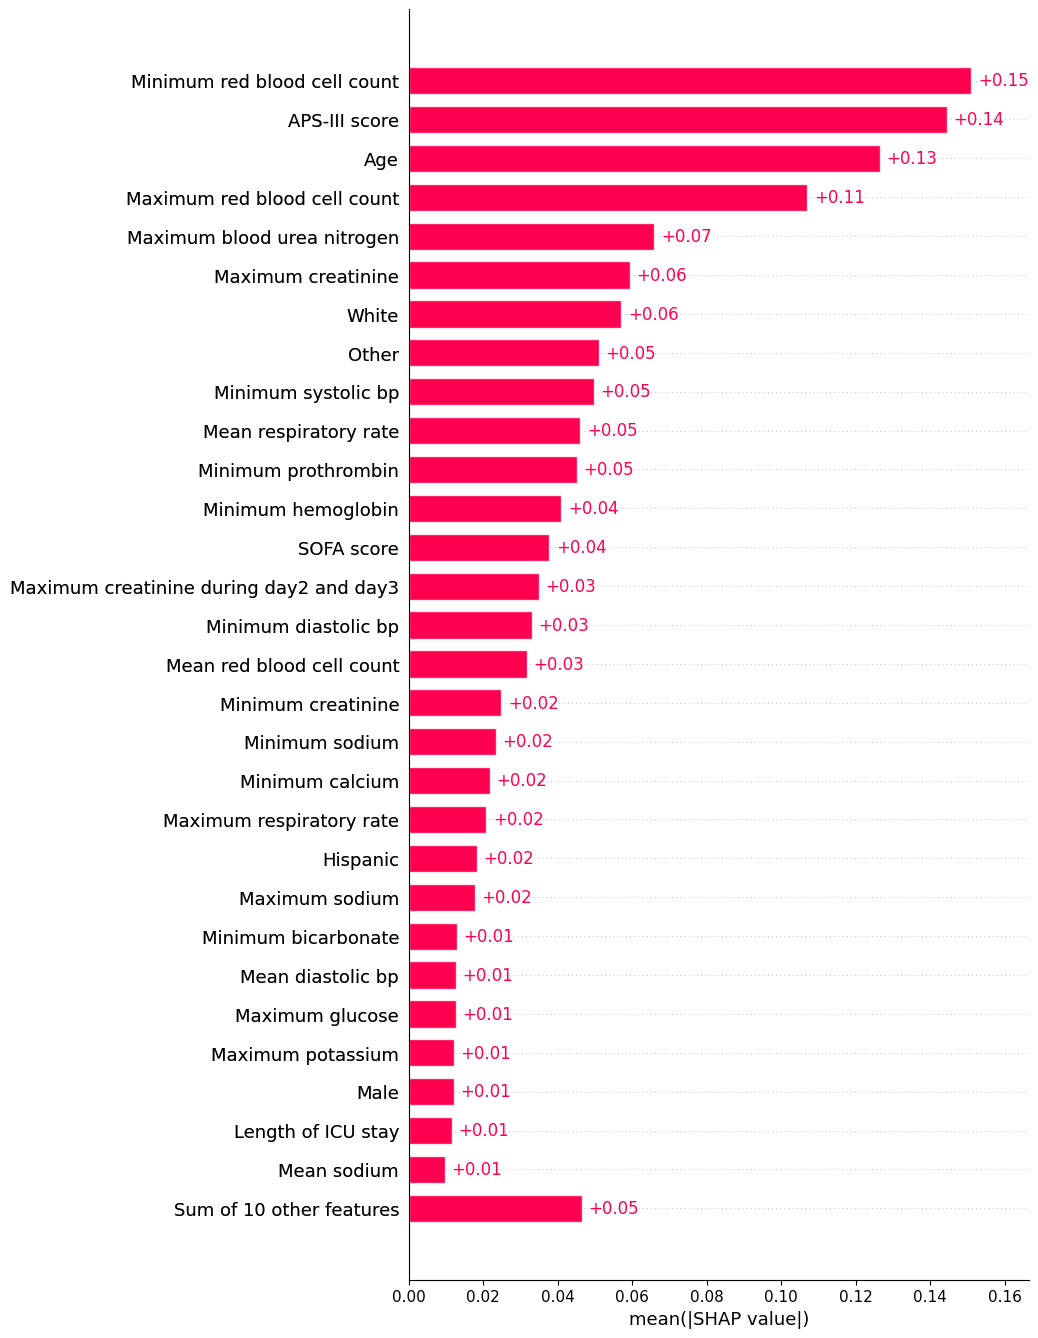

In [231]:
shap.plots.bar(SVM_shap_values, max_display=30)

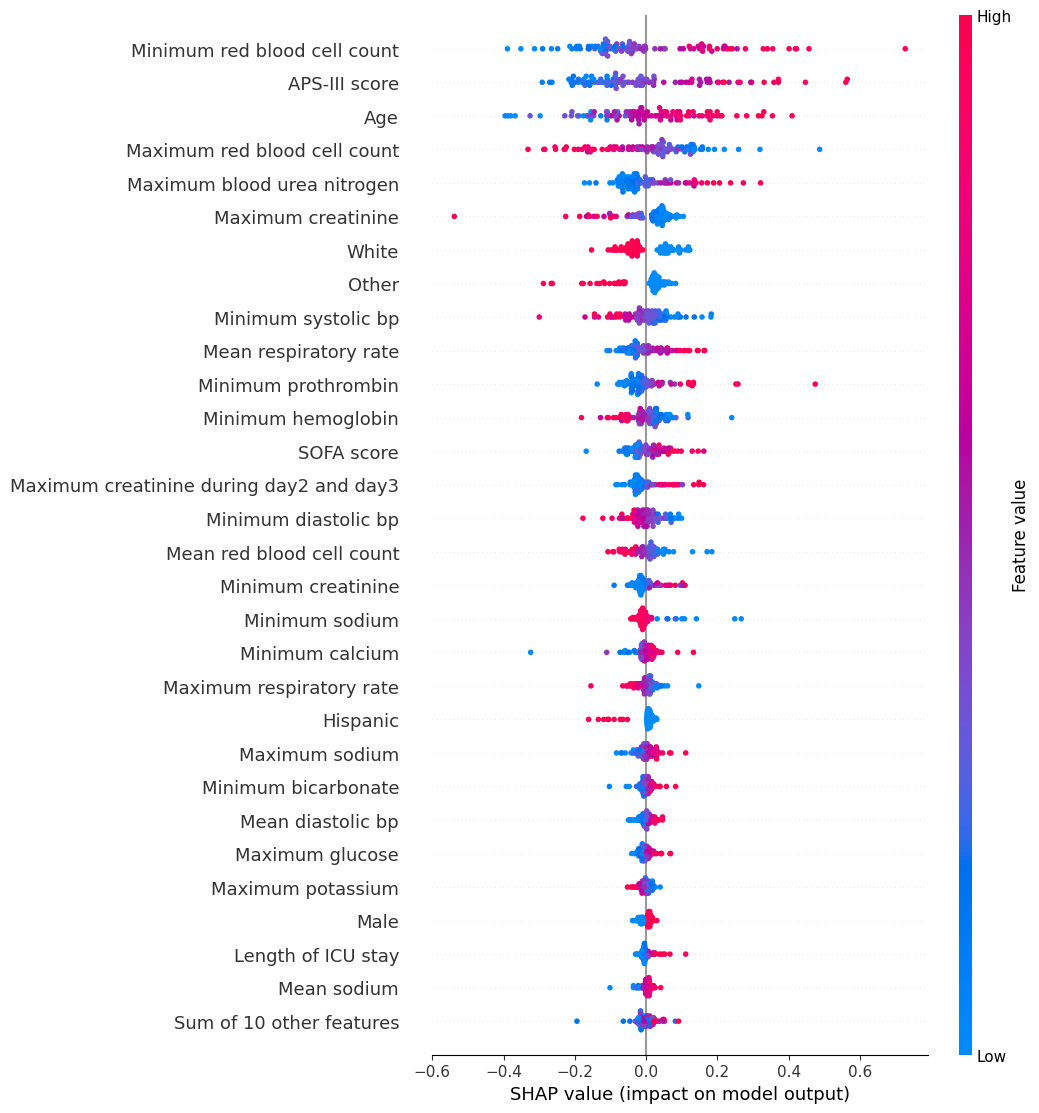

In [232]:
shap.plots.beeswarm(SVM_shap_values, max_display=30)

### backward selection

In [233]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [234]:
selected_features_SVM = print_feature_importances_shap_values(SVM_shap_values, X_test.columns)

In [235]:
## Backward Selection
X = logistic_reg_all_variables['X'][selected_features_SVM]
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    SGDClassifier(max_iter=1000, random_state=1, loss='log_loss')
)

cv_strategy = KFold(n_splits=10, shuffle=True)

In [236]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_SVM_BS = {}
for score_name, scorer in scoring.items():
    perfomances_SVM_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [237]:
perfomances_SVM_BS

{'ROC_auc': 0.738064748750709,
 'Accuracy': 0.6778636736523541,
 'Sensitivity': 0.5950037938099941,
 'Specificity': 0.7532091148428367,
 'PPV': 0.661388935566705,
 'NPV': 0.685028225043246}

### Plot

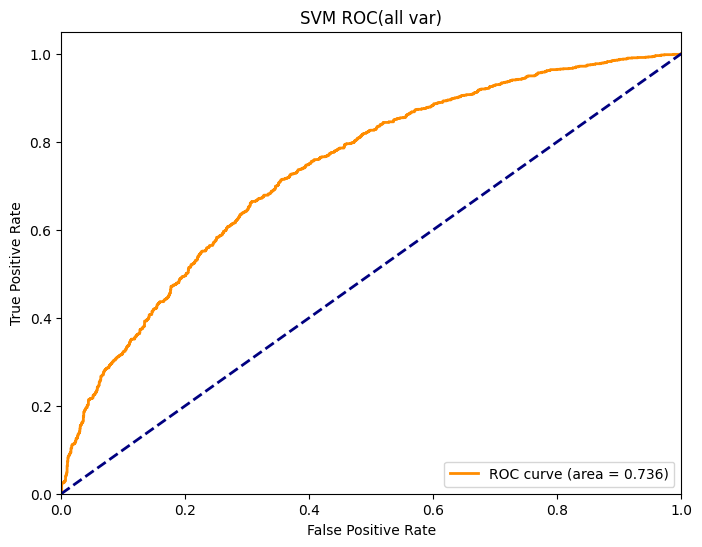

In [239]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = SGDClassifier(max_iter=1000, random_state=1, loss='log_loss')
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_SVM_all, tpr_SVM_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_SVM_all = auc(fpr_SVM_all, tpr_SVM_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM_all, tpr_SVM_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_SVM_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC(all var)')
plt.legend(loc="lower right")
plt.show()

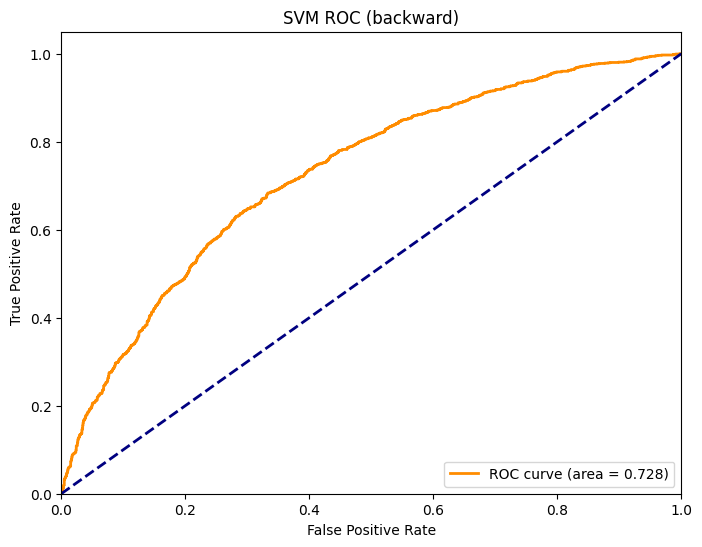

In [241]:
X = logistic_reg_all_variables['X'][selected_features_SVM]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = SGDClassifier(max_iter=1000, random_state=1, loss='log_loss')
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_SVM_backward, tpr_SVM_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_SVM_backward = auc(fpr_SVM_backward, tpr_SVM_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM_backward, tpr_SVM_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_SVM_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# KNN_Y = dataset_copy['mortality']
# KNN_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# KNN_X = KNN_X.drop(columns=['stay_id'])

### Cross-Validation

In [ ]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    KNeighborsClassifier()
)

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_KNN_AllVar = {}
for score_name, scorer in scoring.items():
    perfomances_KNN_AllVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [ ]:
perfomances_KNN_AllVar

{'ROC_auc': 0.6814551807959457,
 'Accuracy': 0.6422211297923943,
 'Sensitivity': 0.5173319216828448,
 'Specificity': 0.7455235535756256,
 'PPV': 0.6269838970081267,
 'NPV': 0.6513486522635701}

### feature importence by SHAP value

In [ ]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = KNeighborsClassifier(n_neighbors=20)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [ ]:
import shap

explainer = shap.Explainer(model.predict, X_test)

shap_values = explainer(X_test)

PermutationExplainer explainer:  12%|█▏        | 576/4672 [1:13:02<8:41:15,  7.64s/it]


KeyboardInterrupt: 

In [ ]:
KNN_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Nu/predicting_mortality_for_ICU_patients/Data/shap_values_for_models/KNN_shap_values.pickle', 'wb') as f:
    pickle.dump(KNN_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Nu/predicting_mortality_for_ICU_patients/Data/shap_values_for_models/KNN_shap_values.pickle', 'rb') as f:
    KNN_shap_values = pickle.load(f)

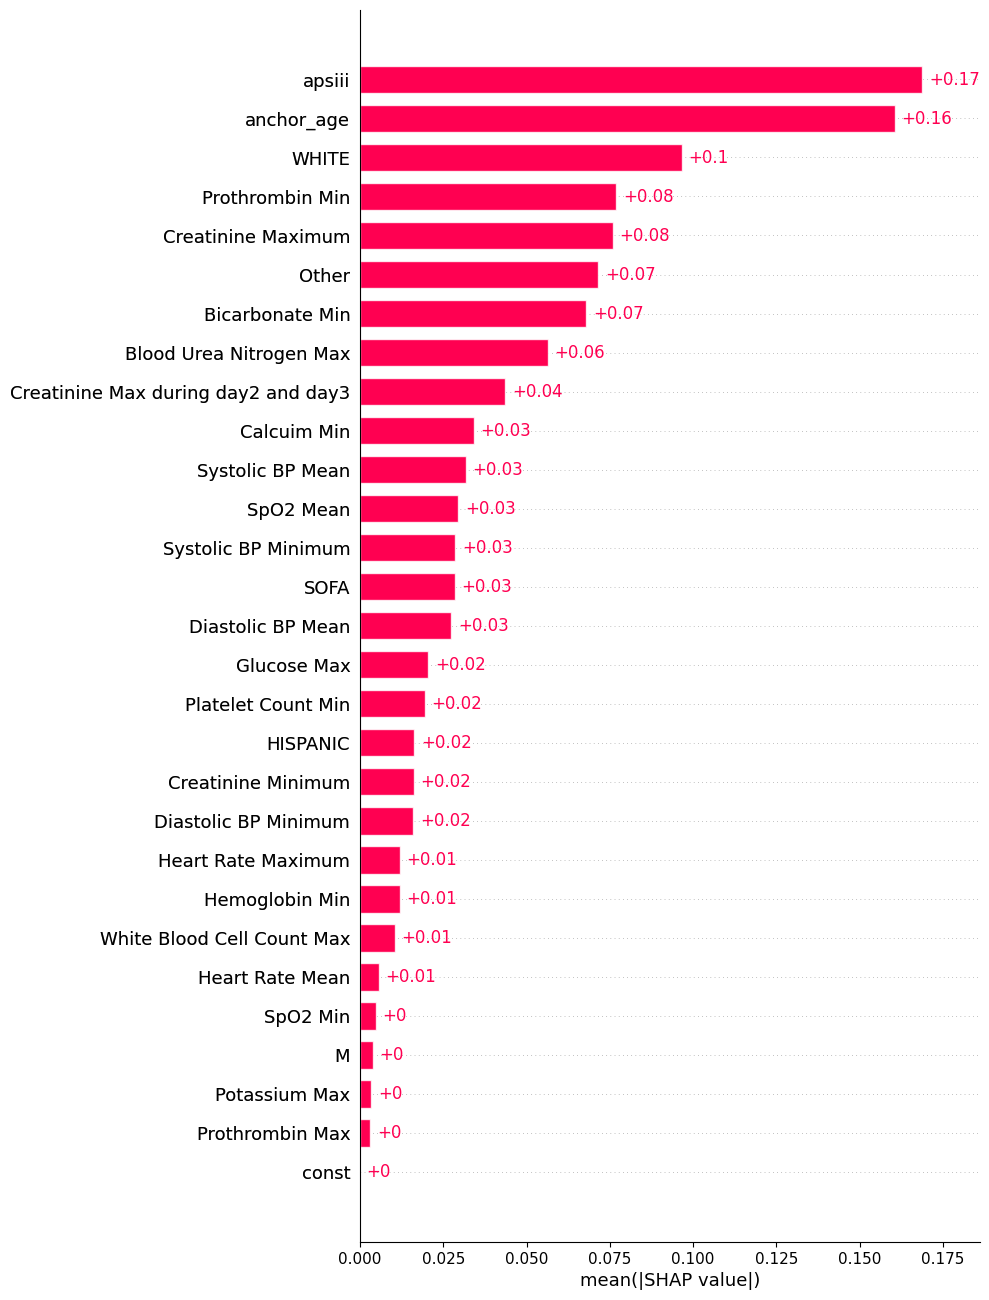

In [ ]:
shap.plots.bar(KNN_shap_values, max_display=30)

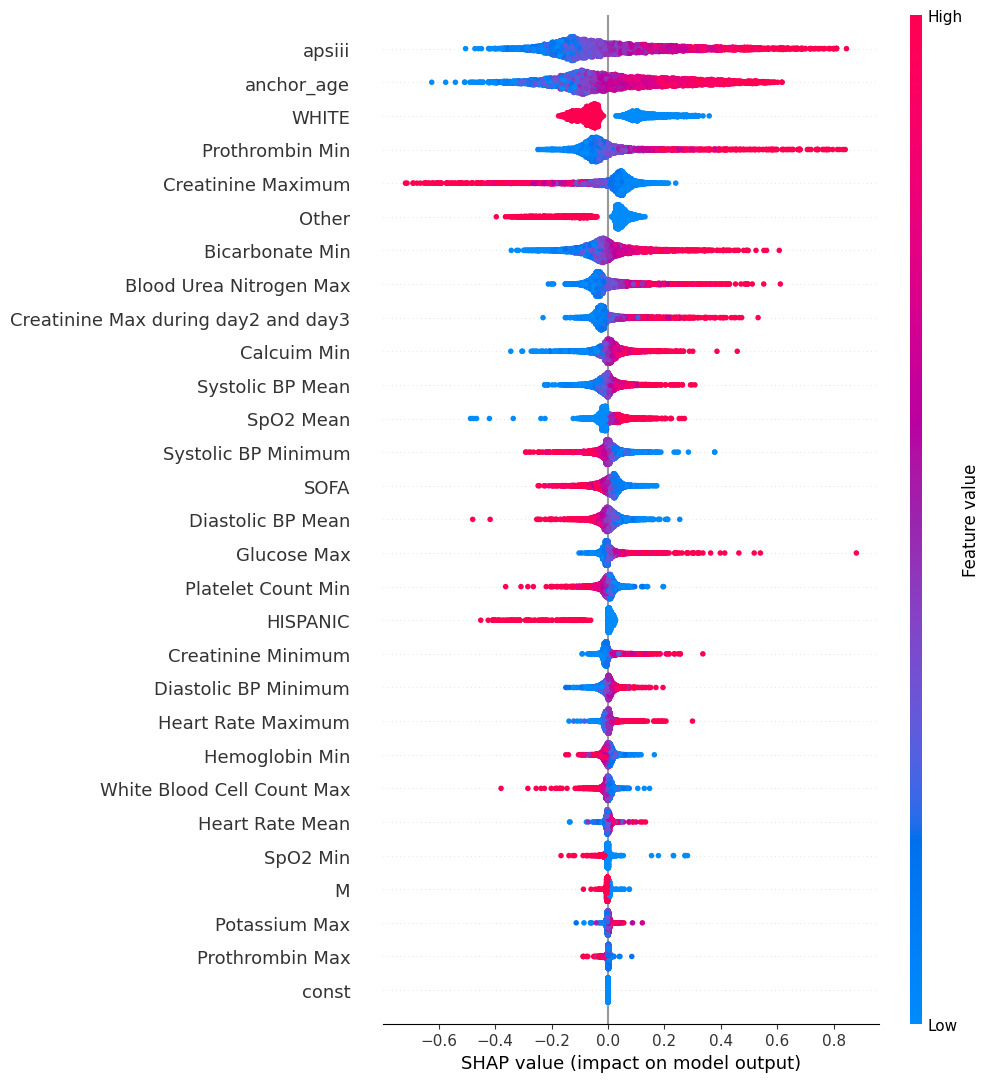

In [ ]:
shap.plots.beeswarm(KNN_shap_values, max_display=30)

### backward selection

In [ ]:
## Backward Selection
X = logistic_reg_backward_selection['X']
y = logistic_reg_backward_selection['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    KNeighborsClassifier()
)

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_KNN_BS = {}
for score_name, scorer in scoring.items():
    perfomances_KNN_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [ ]:
perfomances_KNN_BS

{'ROC_auc': 0.6720296271460471,
 'Accuracy': 0.6349004385849149,
 'Sensitivity': 0.5230392841345537,
 'Specificity': 0.7273757131483888,
 'PPV': 0.6133684354238313,
 'NPV': 0.6484546566781262}

### Plot

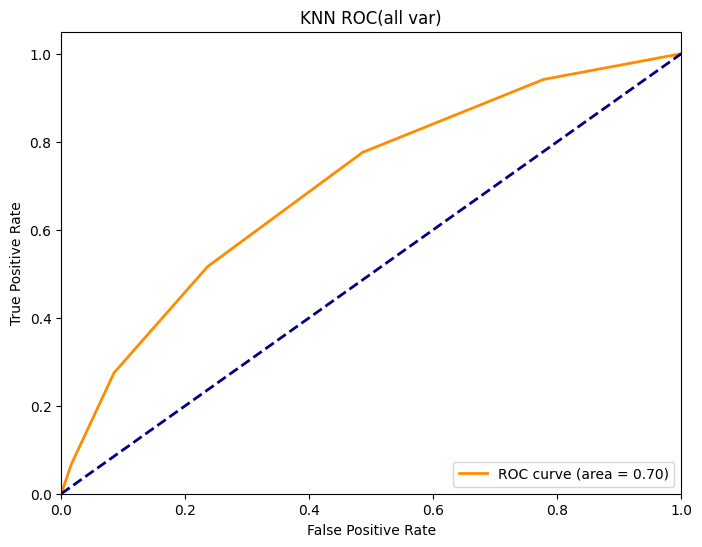

In [ ]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC(all var)')
plt.legend(loc="lower right")
plt.show()

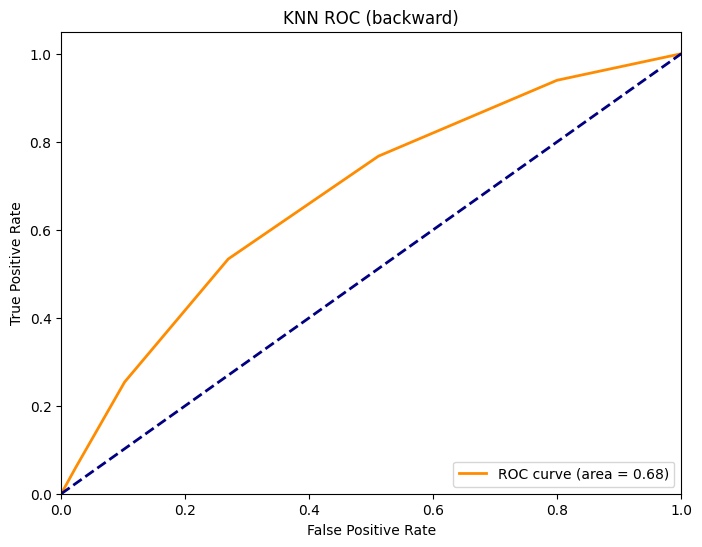

In [ ]:
X = logistic_reg_backward_selection['X']
y = logistic_reg_backward_selection['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Bagging Decision Tree

In [242]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# BagDT_Y = dataset_copy['mortality']
# BagDT_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# BagDT_X = BagDT_X.drop(columns=['stay_id'])

### Cross-Validation

In [243]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [244]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_BagDT_AllVar = {}
for score_name, scorer in scoring.items():
    perfomances_BagDT_AllVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [246]:
perfomances_BagDT_AllVar

{'ROC_auc': 0.7584356654947142,
 'Accuracy': 0.6907229763556049,
 'Sensitivity': 0.6310988267199557,
 'Specificity': 0.739413823283736,
 'PPV': 0.667570455445784,
 'NPV': 0.7080249967963321}

### feature importence by SHAP value

In [257]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)

model.fit(X_train, y_train)

KeyboardInterrupt: 

In [256]:
explainer = shap.Explainer(model.predict, X_test[:100])

shap_values = explainer(X_test[:100])

NotFittedError: This BaggingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [250]:
BagDT_shap_values = shap_values
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/BagDT_shap_values.pickle', 'wb') as f:
    pickle.dump(BagDT_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/BagDT_shap_values.pickle', 'rb') as f:
    BagDT_shap_values = pickle.load(f)

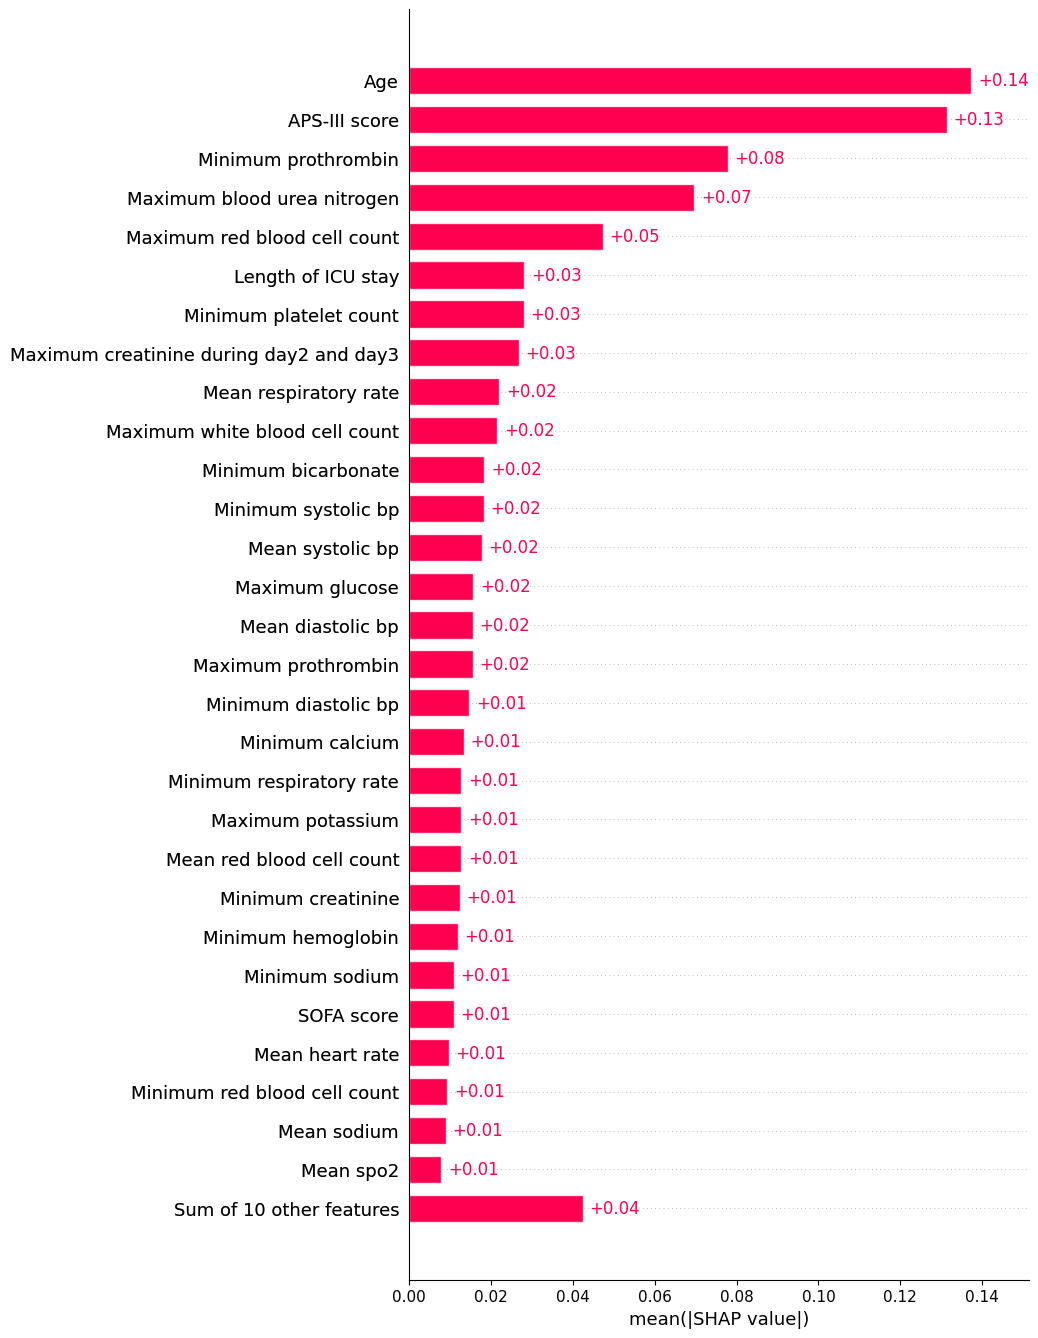

In [251]:
shap.plots.bar(BagDT_shap_values, max_display=30)

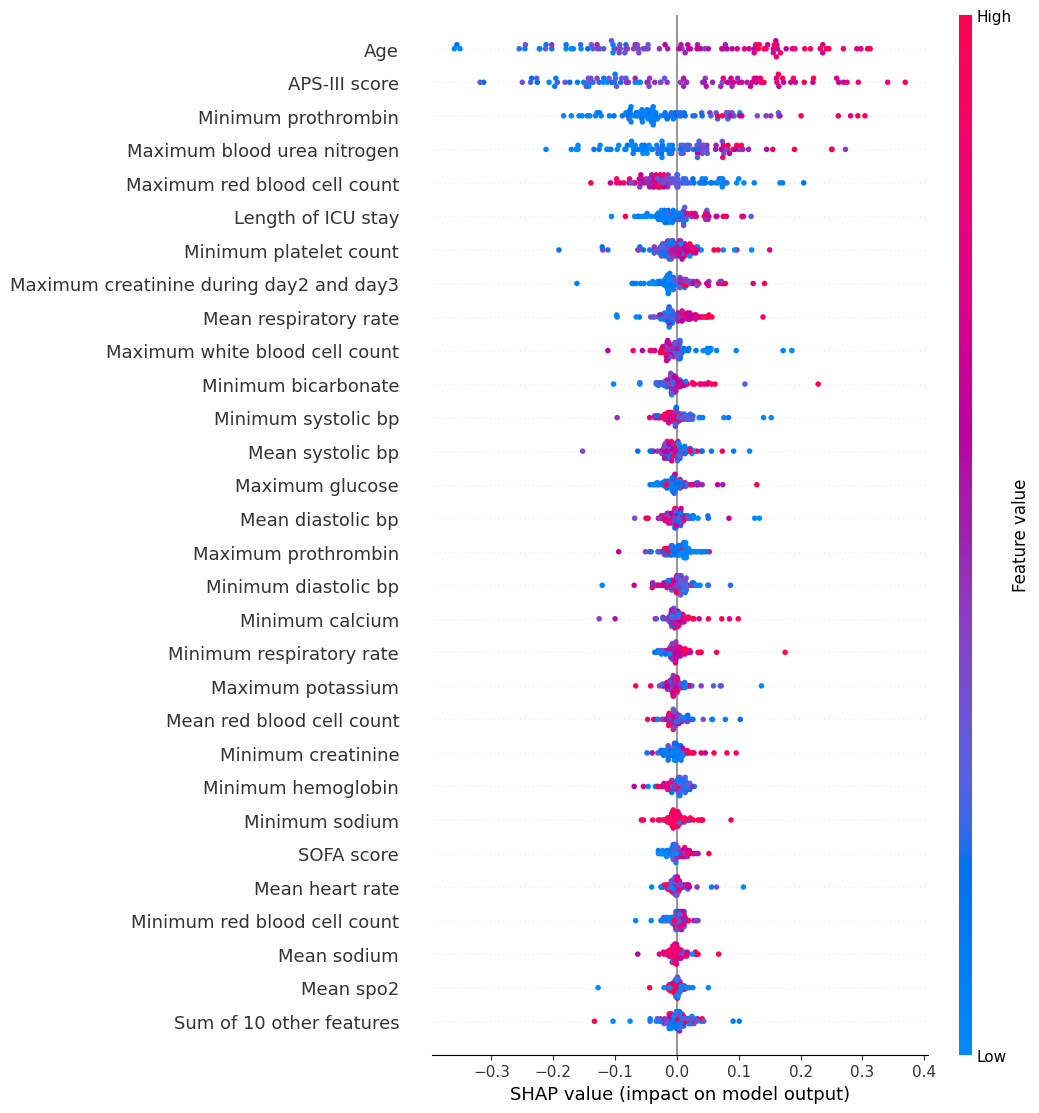

In [252]:
shap.plots.beeswarm(BagDT_shap_values, max_display=30)

### backward selection

In [253]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [254]:
selected_features_BagDT = print_feature_importances_shap_values(BagDT_shap_values, X_test.columns)

In [258]:
## Backward Selection
X = logistic_reg_all_variables['X'][selected_features_BagDT]
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
    # BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=4), n_estimators=100, n_jobs=-1)
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [259]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_BagDT_BS = {}
for score_name, scorer in scoring.items():
    perfomances_BagDT_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [260]:
perfomances_BagDT_BS

{'ROC_auc': 0.7580143582073955,
 'Accuracy': 0.68912812086201,
 'Sensitivity': 0.6318118133495609,
 'Specificity': 0.7382659352482378,
 'PPV': 0.6683031047863859,
 'NPV': 0.7099340955876312}

### Plot

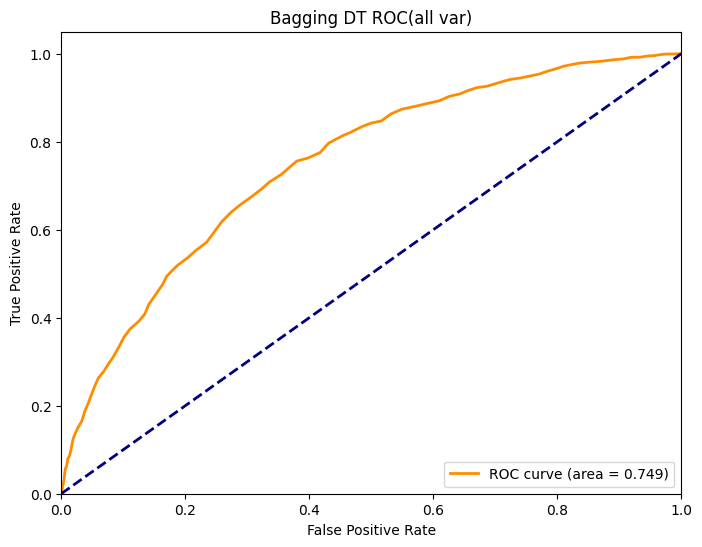

In [261]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_BagDT_all, tpr_BagDT_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_BagDT_all = auc(fpr_BagDT_all, tpr_BagDT_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_BagDT_all, tpr_BagDT_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_BagDT_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging DT ROC(all var)')
plt.legend(loc="lower right")
plt.show()

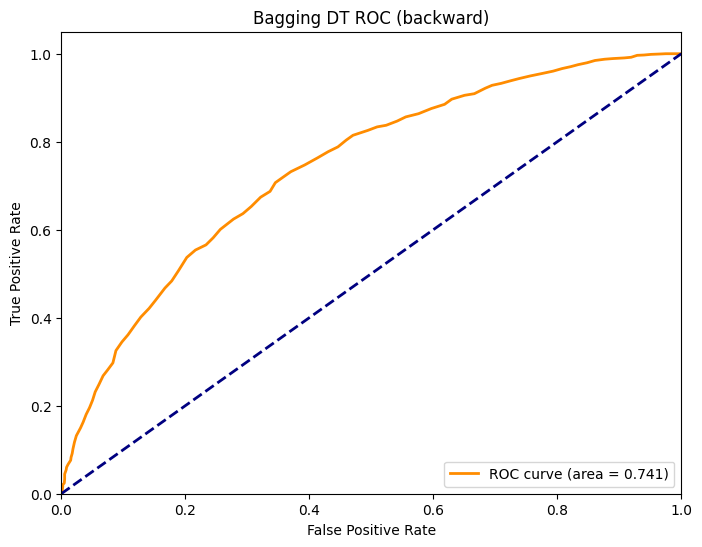

In [262]:
X = logistic_reg_all_variables['X'][selected_features_BagDT]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
# clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=4), n_estimators=100, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_BagDT_backward, tpr_BagDT_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_BagDT_backward = auc(fpr_BagDT_backward, tpr_BagDT_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_BagDT_backward, tpr_BagDT_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_BagDT_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging DT ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Boosting Decision Tree

In [263]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# BoostDT_Y = dataset_copy['mortality']
# BoostDT_X = pd.merge(predictors_continuous, predictors_categorical, how='left', on='stay_id')
# BoostDT_X = BoostDT_X.drop(columns=['stay_id'])

### Cross-Validation

In [265]:
## All Variables
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    HistGradientBoostingClassifier()
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [266]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_BoostDT_AllVar = {}
for score_name, scorer in scoring.items():
    perfomances_BoostDT_AllVar[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [267]:
perfomances_BoostDT_AllVar

{'ROC_auc': 0.7718026434650663,
 'Accuracy': 0.6988301883459852,
 'Sensitivity': 0.6447660156389234,
 'Specificity': 0.7463987815220597,
 'PPV': 0.6757271352050104,
 'NPV': 0.7181016064759144}

### feature importence by SHAP value

In [334]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

model = HistGradientBoostingClassifier()

model.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [335]:
import shap

explainer = shap.Explainer(model.predict, X_test[:500])

shap_values = explainer(X_test[:500])

PermutationExplainer explainer: 501it [03:46,  2.12it/s]


In [336]:
BoostDT_shap_values = shap_values
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/BoostDT_shap_values.pickle', 'wb') as f:
    pickle.dump(BoostDT_shap_values, f)

In [ ]:
with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/BoostDT_shap_values.pickle', 'rb') as f:
    BoostDT_shap_values = pickle.load(f)

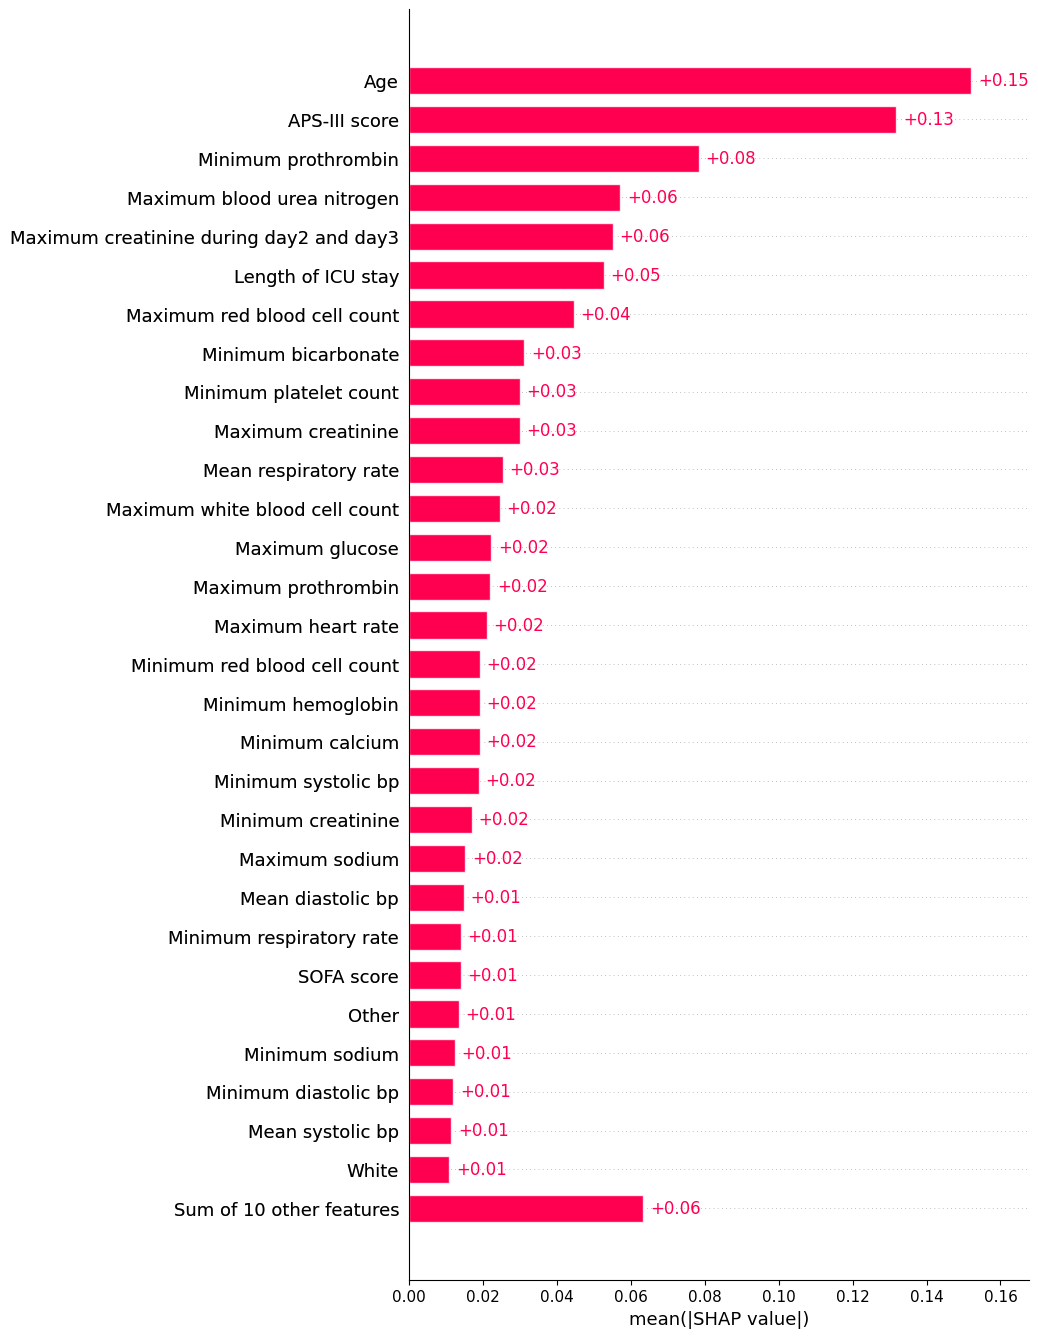

In [337]:
shap.plots.bar(BoostDT_shap_values, max_display=30)

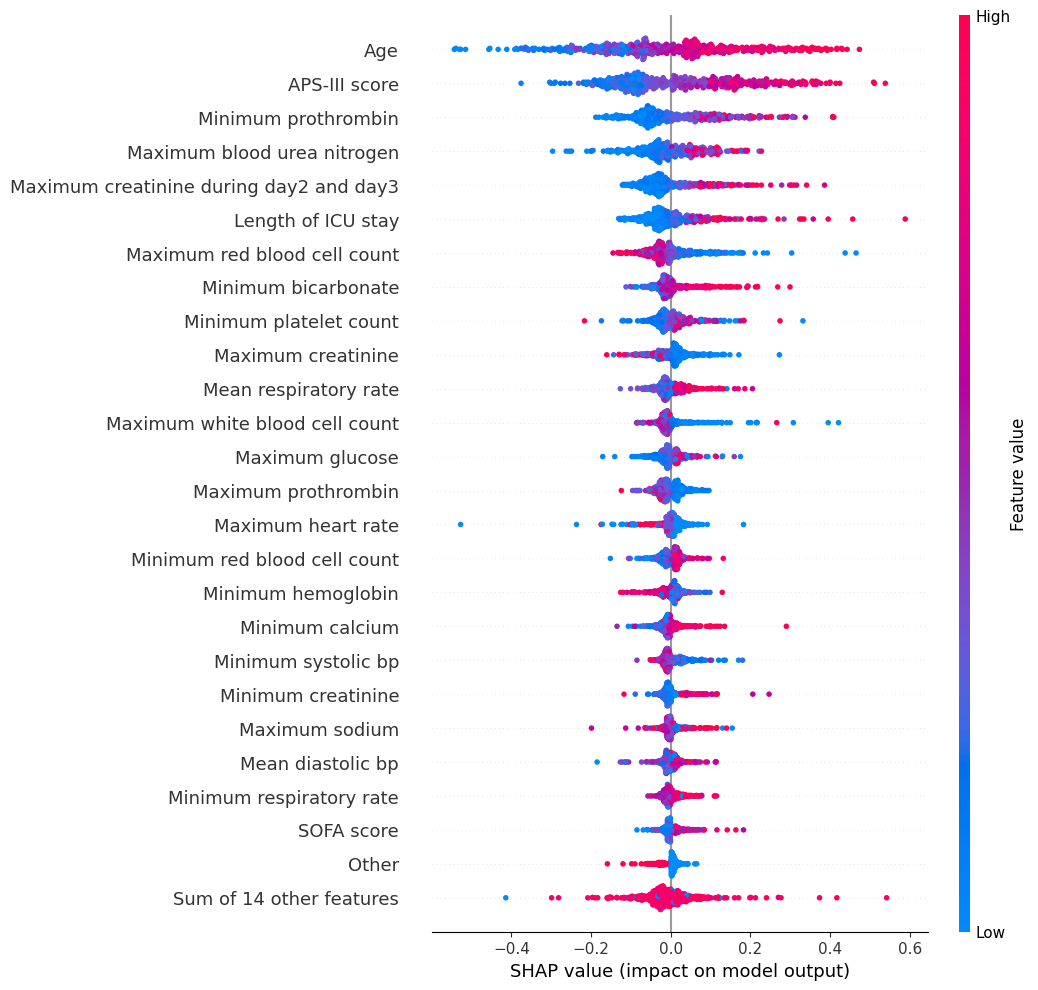

In [338]:
shap.plots.beeswarm(BoostDT_shap_values, max_display=26)

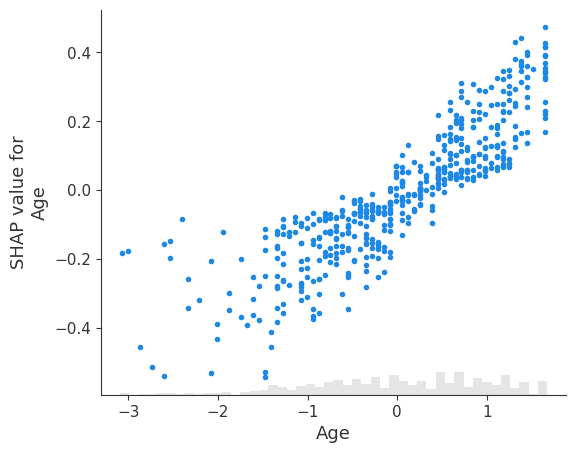

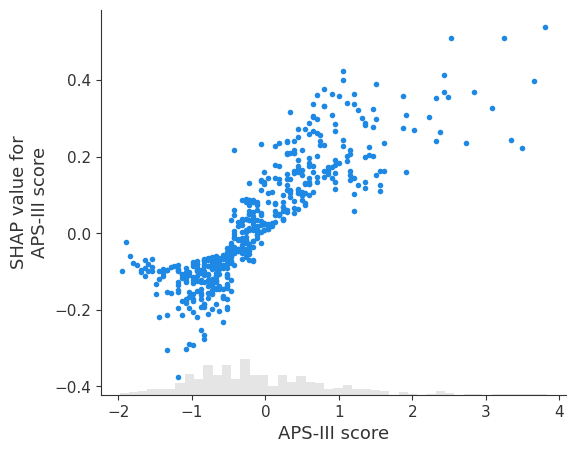

In [339]:
shap.plots.scatter(shap_values[:, "Age"], show=False)
shap.plots.scatter(shap_values[:, "APS-III score"], show=False)

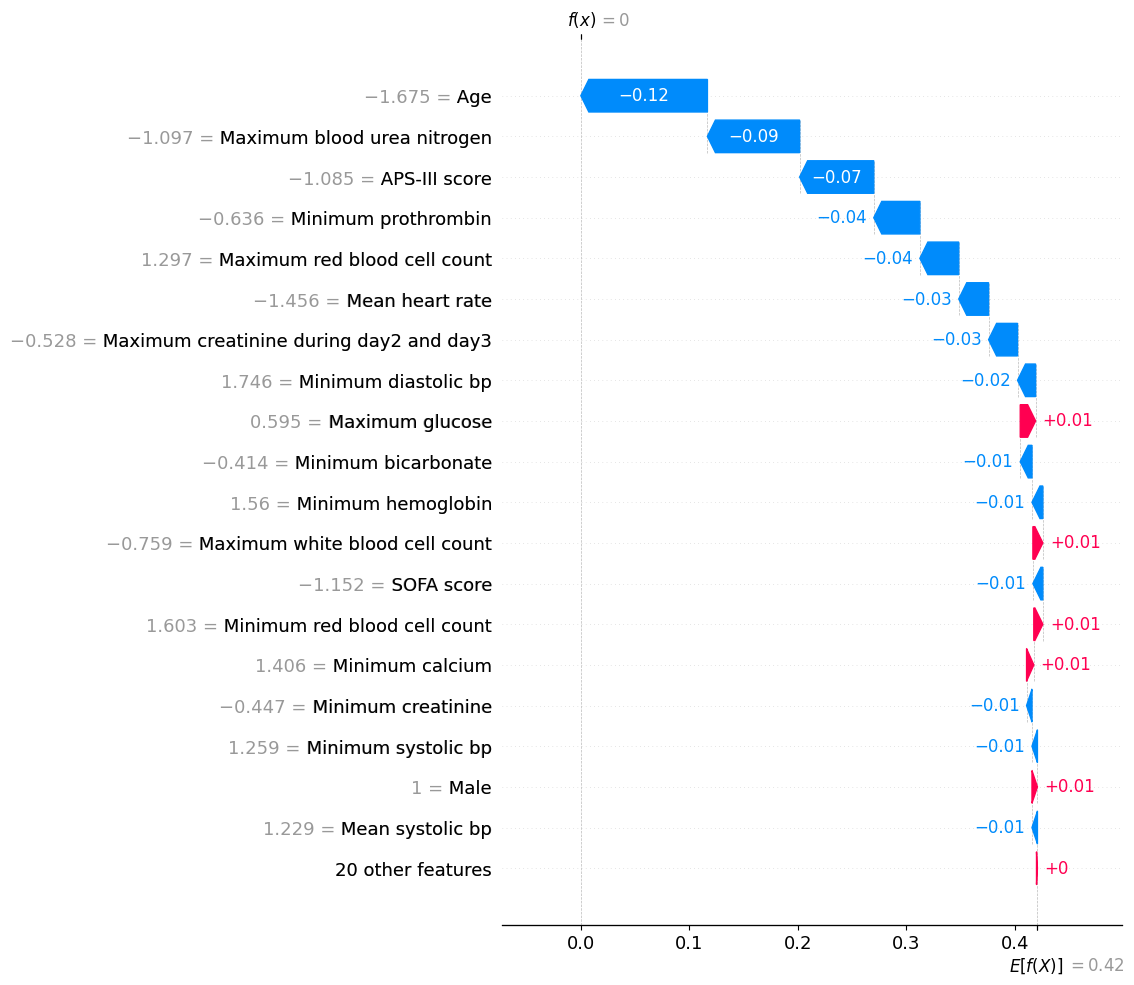

In [278]:
# shap.plots.text(shap_values[10])
shap.plots.waterfall(shap_values[2], max_display=20)

### backward selection

In [279]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    importances_norm = softmax(importances)
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    selected_features = []
    for k, v in feature_importances.items():
        selected_features.append(k)
    #     print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    # print(selected_features)
    return selected_features[:25]


In [280]:
selected_features_BoostDT = print_feature_importances_shap_values(BoostDT_shap_values, X_test.columns)

In [282]:
## Backward Selection
X = logistic_reg_all_variables['X'][selected_features_BoostDT]
y = logistic_reg_all_variables['y']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
continuous_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# model = Pipeline(steps=[('preprocessor', preprocessor), (MLPClassifier(hidden_layer_sizes=(100,), random_state=1))])
model = make_pipeline(
    # preprocessor,
    HistGradientBoostingClassifier()
)

cv_strategy = KFold(n_splits=5, shuffle=True)

In [283]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

def sensitivity(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fn(y_true, y_pred))

def specificity(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fp(y_true, y_pred))

def ppv(y_true, y_pred):
    return tp(y_true, y_pred) / (tp(y_true, y_pred) + fp(y_true, y_pred))

def npv(y_true, y_pred):
    return tn(y_true, y_pred) / (tn(y_true, y_pred) + fn(y_true, y_pred))

scoring = {'ROC_auc': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score),
           'Sensitivity': make_scorer(sensitivity),
           'Specificity': make_scorer(specificity),
           'PPV': make_scorer(ppv),
           'NPV': make_scorer(npv)}

perfomances_BoostDT_BS = {}
for score_name, scorer in scoring.items():
    perfomances_BoostDT_BS[score_name] = cross_val_score(model, X, y, scoring=scorer, cv=cv_strategy).mean()

In [284]:
perfomances_BoostDT_BS

{'ROC_auc': 0.7673393949255953,
 'Accuracy': 0.6956406871043467,
 'Sensitivity': 0.6403925012654267,
 'Specificity': 0.7419565614241401,
 'PPV': 0.6737886965838216,
 'NPV': 0.7137869022523686}

### Plot

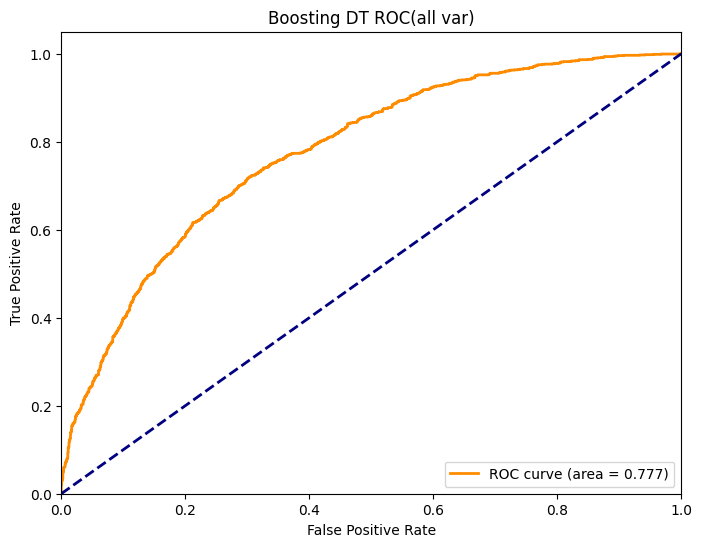

In [348]:
X = logistic_reg_all_variables['X']
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_BoostDT_all, tpr_BoostDT_all, thresholds = roc_curve(y_test, y_probs)

roc_auc_BoostDT_all = auc(fpr_BoostDT_all, tpr_BoostDT_all)

plt.figure(figsize=(8, 6))
plt.plot(fpr_BoostDT_all, tpr_BoostDT_all, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_BoostDT_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Boosting DT ROC(all var)')
plt.legend(loc="lower right")
plt.show()

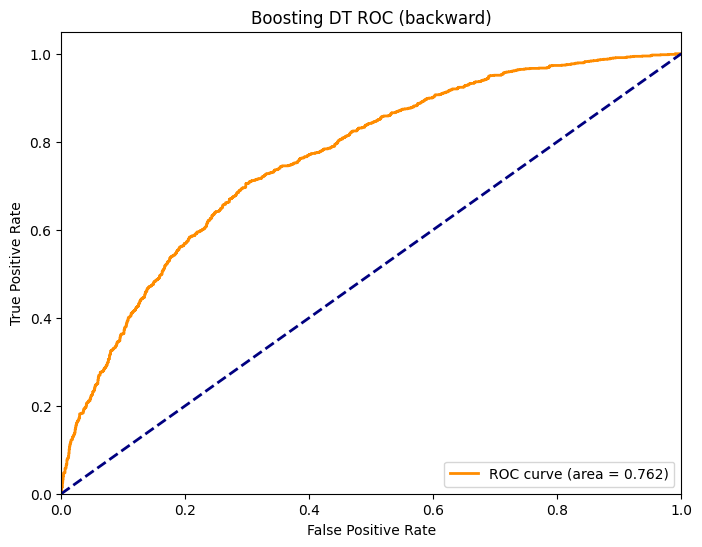

In [286]:
X = logistic_reg_all_variables['X'][selected_features_BoostDT]
y = logistic_reg_all_variables['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

fpr_BoostDT_backward, tpr_BoostDT_backward, thresholds = roc_curve(y_test, y_probs)

roc_auc_BoostDT_backward = auc(fpr_BoostDT_backward, tpr_BoostDT_backward)

plt.figure(figsize=(8, 6))
plt.plot(fpr_BoostDT_backward, tpr_BoostDT_backward, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_BoostDT_backward)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Boosting DT ROC (backward)')
plt.legend(loc="lower right")
plt.show()

## Performance metrics

In [303]:
df_LR_AllVar = pd.DataFrame([perfomances_LR_allVar], index=['LR AllVar'])
df_LR_BS = pd.DataFrame([perfomances_LR_BS], index=['LR BS'])

df_RF_AllVar = pd.DataFrame([perfomences_RF_allVar], index=['RF AllVar'])
df_RF_BS = pd.DataFrame([perfomances_RF_BS], index=['RF BS'])

df_MLP_AllVar = pd.DataFrame([perfomances_MLP_AllVar], index=['MLP AllVar'])
df_MLP_BS = pd.DataFrame([perfomances_MLP_BS], index=['MLP BS'])

df_SVM_AllVar = pd.DataFrame([perfomances_SVM_AllVar], index=['SVM AllVar'])
df_SVM_BS = pd.DataFrame([perfomances_SVM_BS], index=['SVM BS'])

# df_KNN_AllVar = pd.DataFrame([perfomances_KNN_AllVar], index=['KNN AllVar'])
# df_KNN_BS = pd.DataFrame([perfomances_KNN_BS], index=['KNN BS'])

df_BagDT_AllVar = pd.DataFrame([perfomances_BagDT_AllVar], index=['BagDT AllVar'])
df_BagDT_BS = pd.DataFrame([perfomances_BagDT_BS], index=['BagDT BS'])

df_BoostDT_AllVar = pd.DataFrame([perfomances_BoostDT_AllVar], index=['BoostDT AllVar'])
df_BoostDT_BS = pd.DataFrame([perfomances_BoostDT_BS], index=['BoostDT BS'])


performances_clf = pd.concat([df_LR_AllVar, df_LR_BS,
                         df_RF_AllVar, df_RF_BS,
                         df_MLP_AllVar, df_MLP_BS,
                         df_SVM_AllVar, df_SVM_BS,
                        #  df_KNN_AllVar, df_KNN_BS,
                         df_BagDT_AllVar, df_BagDT_BS,
                         df_BoostDT_AllVar, df_BoostDT_BS])

In [304]:
performances_clf.round(4)

ROC_auc  Accuracy  Sensitivity  Specificity   PPV   NPV
LR AllVar         0.750     0.686        0.599        0.758 0.671 0.696
LR BS             0.750     0.687        0.599        0.760 0.673 0.696
RF AllVar         0.761     0.695        0.628        0.747 0.675 0.709
RF BS             0.756     0.689        0.615        0.746 0.668 0.705
MLP AllVar        0.761     0.694        0.649        0.731 0.666 0.716
MLP BS            0.758     0.692        0.639        0.735 0.668 0.714
SVM AllVar        0.737     0.681        0.591        0.754 0.657 0.692
SVM BS            0.738     0.678        0.595        0.753 0.661 0.685
BagDT AllVar      0.758     0.691        0.631        0.739 0.668 0.708
BagDT BS          0.758     0.689        0.632        0.738 0.668 0.710
BoostDT AllVar    0.772     0.699        0.645        0.746 0.676 0.718
BoostDT BS        0.767     0.696        0.640        0.742 0.674 0.714

In [ ]:
performances_clf.round(3)
performances_clf.to_csv('/content/drive/MyDrive/Nu/predicting_mortality_for_ICU_patients/Results/performences_1.csv', index=False)

In [ ]:
performances_clf.round(3)
performances_clf.to_csv('/content/drive/MyDrive/Nu/predicting_mortality_for_ICU_patients/Results/performences_2.csv', index=False)

In [ ]:
performances_clf.round(3)
performances_clf.to_csv('/content/drive/MyDrive/Project_1_with_ye/Results/performences_3.csv', index=False)

## Plot of ROC

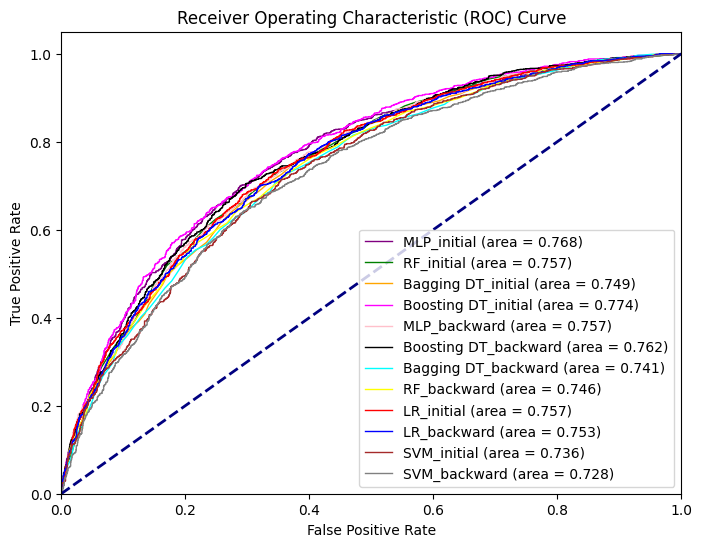

In [289]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_MLP_all, tpr_MLP_all, color='purple', lw=1, label='MLP_initial (area = %0.3f)' % roc_auc_MLP_all)
plt.plot(fpr_RF_all, tpr_RF_all, color='green', lw=1, label='RF_initial (area = %0.3f)' % roc_auc_RF_all)
plt.plot(fpr_BagDT_all, tpr_BagDT_all, color='orange', lw=1, label='Bagging DT_initial (area = %0.3f)' % roc_auc_BagDT_all)
plt.plot(fpr_BoostDT_all, tpr_BoostDT_all, color='magenta', lw=1, label='Boosting DT_initial (area = %0.3f)' % roc_auc_BoostDT_all)
plt.plot(fpr_MLP_backward, tpr_MLP_backward, color='pink', lw=1, label='MLP_backward (area = %0.3f)' % roc_auc_MLP_backward)
plt.plot(fpr_BoostDT_backward, tpr_BoostDT_backward, color='black', lw=1, label='Boosting DT_backward (area = %0.3f)' % roc_auc_BoostDT_backward)
plt.plot(fpr_BagDT_backward, tpr_BagDT_backward, color='cyan', lw=1, label='Bagging DT_backward (area = %0.3f)' % roc_auc_BagDT_backward)
plt.plot(fpr_RF_backward, tpr_RF_backward, color='yellow', lw=1, label='RF_backward (area = %0.3f)' % roc_auc_RF_backward)
plt.plot(fpr_LR_all, tpr_LR_all, color='red', lw=1, label='LR_initial (area = %0.3f)' % roc_auc_LR_all)
plt.plot(fpr_LR_backward, tpr_LR_backward, color='blue', lw=1, label='LR_backward (area = %0.3f)' % roc_auc_LR_backward)
plt.plot(fpr_SVM_all, tpr_SVM_all, color='brown', lw=1, label='SVM_initial (area = %0.3f)' % roc_auc_SVM_all)
plt.plot(fpr_SVM_backward, tpr_SVM_backward, color='grey', lw=1, label='SVM_backward (area = %0.3f)' % roc_auc_SVM_backward)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

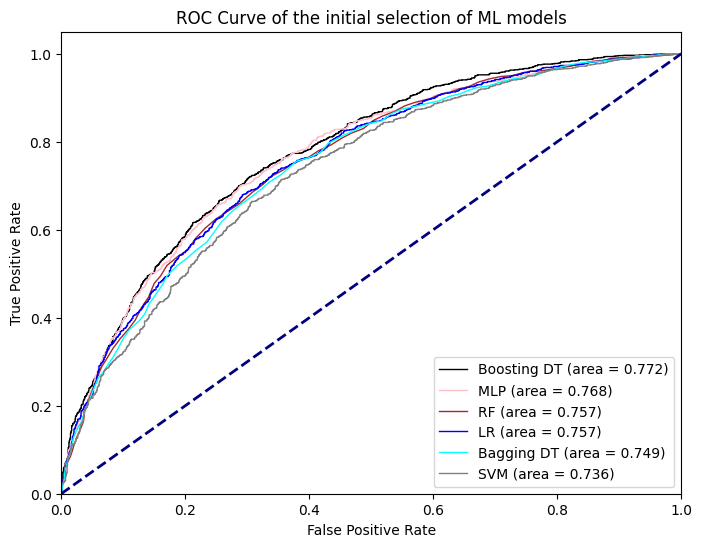

In [350]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_BoostDT_all, tpr_BoostDT_all, color='black', lw=1, label='Boosting DT (area = %0.3f)' % 0.772)
plt.plot(fpr_MLP_all, tpr_MLP_all, color='pink', lw=1, label='MLP (area = %0.3f)' % roc_auc_MLP_all)
plt.plot(fpr_RF_all, tpr_RF_all, color='brown', lw=1, label='RF (area = %0.3f)' % roc_auc_RF_all)
plt.plot(fpr_LR_all, tpr_LR_all, color='blue', lw=1, label='LR (area = %0.3f)' % roc_auc_LR_all)
plt.plot(fpr_BagDT_all, tpr_BagDT_all, color='cyan', lw=1, label='Bagging DT (area = %0.3f)' % roc_auc_BagDT_all)
plt.plot(fpr_SVM_all, tpr_SVM_all, color='grey', lw=1, label='SVM (area = %0.3f)' % roc_auc_SVM_all)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the initial selection of ML models')
plt.legend(loc="lower right")
plt.show()

In [340]:
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/ROC_ML_initial.pickle', 'wb') as f:
    pickle.dump([fpr_BoostDT_all, tpr_BoostDT_all, roc_auc_BoostDT_all,
                 fpr_MLP_all, tpr_MLP_all, roc_auc_MLP_all,
                 fpr_RF_all, tpr_RF_all, roc_auc_RF_all,
                 fpr_LR_all, tpr_LR_all, roc_auc_LR_all,
                 fpr_BagDT_all, tpr_BagDT_all, roc_auc_BagDT_all,
                 fpr_SVM_all, tpr_SVM_all, roc_auc_SVM_all], f)

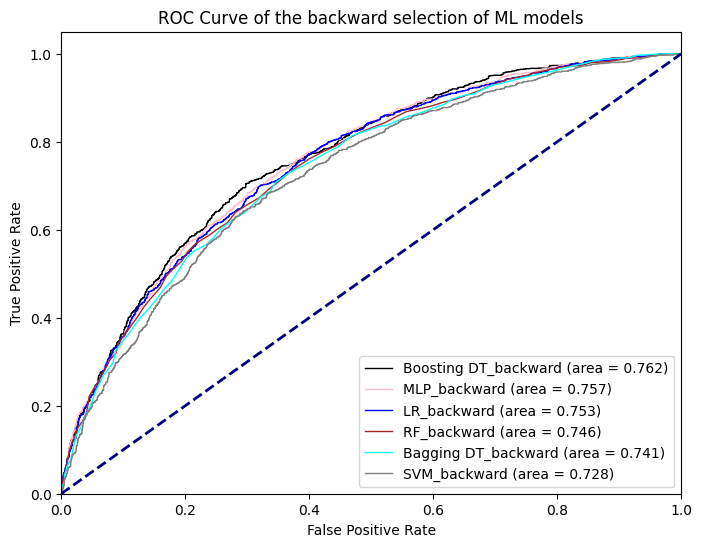

In [332]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_BoostDT_backward, tpr_BoostDT_backward, color='black', lw=1, label='Boosting DT_backward (area = %0.3f)' % roc_auc_BoostDT_backward)
plt.plot(fpr_MLP_backward, tpr_MLP_backward, color='pink', lw=1, label='MLP_backward (area = %0.3f)' % roc_auc_MLP_backward)
plt.plot(fpr_LR_backward, tpr_LR_backward, color='blue', lw=1, label='LR_backward (area = %0.3f)' % roc_auc_LR_backward)
plt.plot(fpr_RF_backward, tpr_RF_backward, color='brown', lw=1, label='RF_backward (area = %0.3f)' % roc_auc_RF_backward)
plt.plot(fpr_BagDT_backward, tpr_BagDT_backward, color='cyan', lw=1, label='Bagging DT_backward (area = %0.3f)' % roc_auc_BagDT_backward)
plt.plot(fpr_SVM_backward, tpr_SVM_backward, color='grey', lw=1, label='SVM_backward (area = %0.3f)' % roc_auc_SVM_backward)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the backward selection of ML models')
plt.legend(loc="lower right")
plt.show()

In [341]:
import pickle

with open('/content/drive/MyDrive/Project_1_with_ye/Data/dataset_2/shap_values_for_models/ROC_ML_backward.pickle', 'wb') as f:
    pickle.dump([fpr_BoostDT_backward, tpr_BoostDT_backward, roc_auc_BoostDT_backward,
                 fpr_MLP_backward, tpr_MLP_backward, roc_auc_MLP_backward,
                 fpr_RF_backward, tpr_RF_backward, roc_auc_RF_backward,
                 fpr_LR_backward, tpr_LR_backward, roc_auc_LR_backward,
                 fpr_BagDT_backward, tpr_BagDT_backward, roc_auc_BagDT_backward,
                 fpr_SVM_backward, tpr_SVM_backward, roc_auc_SVM_backward], f)

## Select features by SHAP

In [ ]:
LR_selected_features

['apsiii',
 'Red Blood Cell Count Max',
 'Red Blood Cell Count Min',
 'anchor_age',
 'Creatinine Maximum',
 'Blood Urea Nitrogen Max',
 'WHITE',
 'Prothrombin Min',
 'Creatinine Max during day2 and day3',
 'Other',
 'Hemoglobin Min',
 'Creatinine Minimum',
 'icu_length',
 'Systolic BP Minimum',
 'Bicarbonate Min',
 'Respiratory Rate Mean',
 'Red Blood Cell Count Mean',
 'SOFA',
 'Respiratory Rate Max',
 'Respiratory Rate Min',
 'Heart Rate Mean',
 'Systolic BP Mean',
 'M',
 'Glucose Max',
 'Calcuim Min']

In [300]:
set1 = set(LR_selected_features)
set2 = set(selected_features_RF)
set3 = set(selected_features_MLP)
set4 = set(selected_features_SVM)
set5 = set(selected_features_BagDT)
set6 = set(selected_features_BoostDT)

common_elements = set1.intersection(set2)
common_elements = common_elements.intersection(set3).intersection(set4).intersection(set5).intersection(set6)
print(common_elements)  # Output: {3, 4}

{'Minimum creatinine', 'Minimum hemoglobin', 'Minimum diastolic bp', 'APS-III score', 'Minimum prothrombin', 'Minimum bicarbonate', 'Maximum blood urea nitrogen', 'Age', 'SOFA score', 'Minimum systolic bp', 'Maximum creatinine during day2 and day3', 'Maximum red blood cell count', 'Mean respiratory rate'}
